In [1]:
# THIS FILE IS TO VISUALIZE COLLECTED DATA, RESULTS AND IMPLEMENTS THE SELECTION ALGORITHM

import os
import pandas as pd
pd.options.display.max_rows = 10
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.metrics import mean_squared_error
from joblib import dump, load
from sklearn import linear_model
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler
import argparse
import os
import pandas as pd
import tensorflow as tf
import time
import logging
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import RegressorChain
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
import lightgbm as lightgbm
from sklearn.inspection import permutation_importance

from datetime import timedelta
cantonKeys = ['AG','AI','AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG','ZH']

numberOfInputWeeks = 3 # must be equal to the number of input weeks set in data preperator
numberOfOutputWeeks = 4 # must be equal to the number of output week set in data preperator


cantonKeys = ['AG','AI','AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG','ZH']
data = pd.read_csv("completedata.csv")


outputCategories = ['case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity_7dayAverage',
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage'
                   ]

plottingDict = {
    'case_inz_entries_7dayAverage': '7 day case incidence average',
                  'hosp_inz_entries_7dayAverage': '7 day hospitalization incidence average',
                  'death_inz_entries_7dayAverage': '7 day death incidence average',
                  'testPositvity_7dayAverage': '7 day test positivity average',
                  'transit_stations_percent_change_from_baseline_7dayAverage': '7 day transit station mobility average',
                  'workplaces_percent_change_from_baseline_7dayAverage': '7 day workplace mobility average'
}


numberOfOutputs = len(outputCategories)

split = numberOfOutputs * numberOfOutputWeeks + 2


train_features = data[data['category']=='train'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
train_labels = data[data['category']=='train'].iloc[:,-split:-2]
validation1_features = data[data['category']=='validation 1'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
validation1_labels = data[data['category']=='validation 1'].iloc[:,-split:-2]
validation2_features = data[data['category']=='validation 2'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
validation2_labels = data[data['category']=='validation 2'].iloc[:,-split:-2]

test1_features = data[data['category']=='test 1'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
test1_labels = data[data['category']=='test 1'].iloc[:,-split:-2]
test2_features = data[data['category']=='test 2'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
test2_labels = data[data['category']=='test 2'].iloc[:,-split:-2]

display(train_features.shape)
display(train_labels.shape)


(8646, 479)

(8646, 24)

,geoRegion,datum,entries,sumTotal,timeframe_7d,offset_last7d,sumTotal_last7d,timeframe_14d,offset_last14d,sumTotal_last14d,...,inzsum14d,sumdelta7d,inzdelta7d,type,type_variant,version,datum_unit,entries_letzter_stand,entries_neu_gemeldet,entries_diff_last
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,CH,2020-02-24,1,1,False,698581,0,False,697044,0,...,NaN,NaN,NaN,COVID19Cases,NaN,2021-06-25_07-49-37,day,1,0,109
2020-02-25,CH,2020-02-25,1,2,False,698581,0,False,697044,0,...,NaN,NaN,NaN,COVID19Cases,NaN,2021-06-25_07-49-37,day,1,0,109
2020-02-26,CH,2020-02-26,10,12,False,698581,0,False,697044,0,...,NaN,NaN,NaN,COVID19Cases,NaN,2021-06-25_07-49-37,day,10,0,109
2020-02-27,CH,2020-02-27,10,22,False,698581,0,False,697044,0,...,NaN,NaN,NaN,COVID19Cases,NaN,2021-06-25_07-49-37,day,10,0,109
2020-02-28,CH,2020-02-28,10,32,False,698581,0,False,697044,0,...,NaN,NaN,NaN,COVID19Cases,NaN,2021-06-25_07-49-37,day,10,0,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-25,CH,2020-05-25,15,30736,False,698581,0,False,697044,0,...,4.10,-19.0,-0.22,COVID19Cases,NaN,2021-06-25_07-49-37,day,15,0,109
2020-05-26,CH,2020-05-26,18,30754,False,698581,0,False,697044,0,...,3.82,-18.0,-0.21,COVID19Cases,NaN,2021-06-25_07-49-37,day,18,0,109
2020-05-27,CH,2020-05-27,25,30779,False,698581,0,False,697044,0,...,3.68,-4.0,-0.05,COVID19Cases,NaN,2021-06-25_07-49-37,day,25,0,109


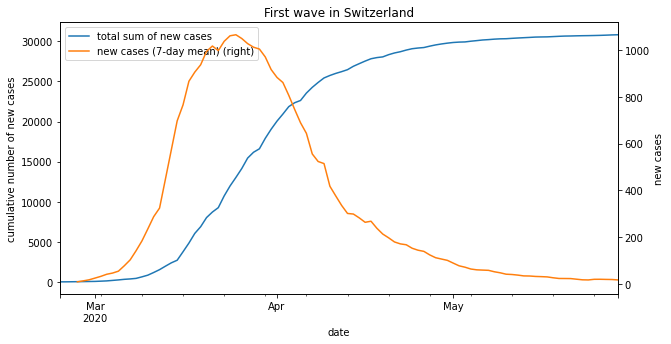

In [3]:
# log curve

logCurve = pd.read_csv("data/FOPH/data/COVID19Cases_geoRegion.csv")
logCurve = logCurve[logCurve['geoRegion']=='CH'] #.set_index('datum')
#logCurve.index = pd.to_datetime(logCurve.index) 

logCurve['date'] = pd.to_datetime(logCurve['datum']) 
logCurve = logCurve[logCurve['date']<'2020-05-30']
logCurve = logCurve.set_index('date')
display(logCurve)
logCurve.rename(columns = {'sumTotal':'total sum of new cases', 'mean7d':'new cases (7-day mean)'},inplace=True)
fig = logCurve[['total sum of new cases','new cases (7-day mean)']].plot(kind='line', xlabel='date', ylabel='cumulative number of new cases', title='First wave in Switzerland', secondary_y=['new cases (7-day mean)'],figsize=(10,5))
#logCurve[[]].plot(kind='line', xlabel='date', ylabel='cumulative number of cases', title='Cumulative cases in Switzerland', figsize=(10,5))
fig.right_ax.set_ylabel('new cases')

fig.get_figure().savefig('plots/logistic.png')


In [3]:
# LOAD THE RESULTS

#validation1And2_labels = data[(data['category']=='validation 1') | (data['category']=='validation 2')].iloc[:,-split:-2]
#validation1And2_features = data[(data['category']=='validation 1') | (data['category']=='validation 2')].iloc[:,0:-split].drop(['lastInputDay'], axis=1)



# loading all the Keras and Sklearn models which were trained once
results = pd.read_csv("results.csv", low_memory=False)
results = results.append(pd.read_csv("results_sklearn.csv", low_memory=False))
results = results.append(pd.read_csv("results_sklearn_tuned.csv", low_memory=False))
results = results.append(pd.read_csv("results_sklearn_tuned2.csv", low_memory=False))

# loading all Keras models which were trained 30 times
resultSelection = pd.read_csv("results_selection.csv", low_memory=False)
resultSelection['modelClass'] = 'Keras mean'
results = results.append(resultSelection)

# loading all sklearn model which were trained 30 times
resultSelectionSklearn = pd.read_csv("results_selection_sklearn.csv", low_memory=False)
resultSelectionSklearn['modelClass'] = resultSelectionSklearn['modelClass'] + " mean"
results = results.append(resultSelectionSklearn)



# attach baselines
for task in outputCategories: # for all output tasks
    for outputWeekNumber in range(0,numberOfOutputWeeks): # for every output week
        # get the ground truth
        groundtruth1 = validation1_labels[["output_"+task+"_"+str(outputWeekNumber)]]
        groundtruth2 = validation2_labels[["output_"+task+"_"+str(outputWeekNumber)]]
   
        # get the easy baseline (is the same for all output weeks)
        last_value_baseline1 = validation1_features[[task+"_last_"+str(numberOfInputWeeks-1)]]
        last_value_baseline2 = validation2_features[[task+"_last_"+str(numberOfInputWeeks-1)]]
        
        last_value_baseline1_rmse = np.sqrt(mean_squared_error(last_value_baseline1,groundtruth1))
        last_value_baseline2_rmse = np.sqrt(mean_squared_error(last_value_baseline2,groundtruth2))
        
        results.loc[(results.task == task) & (results.week == outputWeekNumber),'last value baseline 1 rmse']=last_value_baseline1_rmse
        results.loc[(results.task == task) & (results.week == outputWeekNumber),'last value baseline 2 rmse']=last_value_baseline2_rmse
        
        

   
results



,Unnamed: 0,modelClass,task,week,model rmse 1,model rmse 2,isMultiWeek,hiddenLayers,numberOfhiddenLayers,isTwoWay,...,modelId,modelIdNumber,l1_ratio,max_features,n_estimators,min_samples_leaf,tol,iteration,last value baseline 1 rmse,last value baseline 2 rmse
0,0,Keras,case_inz_entries_7dayAverage,0,8.750585,6.842526,True,[20],1.0,False,...,modelClass=Keras/isMultiWeek=True/hiddenLayers...,597,NaN,NaN,NaN,NaN,NaN,NaN,6.339356,15.058855
1,1,Keras,case_inz_entries_7dayAverage,1,13.744389,9.309519,True,[20],1.0,False,...,modelClass=Keras/isMultiWeek=True/hiddenLayers...,597,NaN,NaN,NaN,NaN,NaN,NaN,8.531462,25.559603
2,2,Keras,case_inz_entries_7dayAverage,2,18.621451,10.661099,True,[20],1.0,False,...,modelClass=Keras/isMultiWeek=True/hiddenLayers...,597,NaN,NaN,NaN,NaN,NaN,NaN,10.986179,31.134417
3,3,Keras,case_inz_entries_7dayAverage,3,21.064762,12.526844,True,[20],1.0,False,...,modelClass=Keras/isMultiWeek=True/hiddenLayers...,597,NaN,NaN,NaN,NaN,NaN,NaN,13.833168,33.595827
4,4,Keras,hosp_inz_entries_7dayAverage,0,0.404281,0.383035,True,[20],1.0,False,...,modelClass=Keras/isMultiWeek=True/hiddenLayers...,597,NaN,NaN,NaN,NaN,NaN,NaN,0.496069,0.634250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6235,6235,RandomForrest mean,workplaces_percent_change_from_baseline_7dayAv...,3,6.060057,3.227843,True,NaN,NaN,NaN,...,modelClass=RandomForrest/isMultiWeek=True/n_es...,0,NaN,auto,1000.0,4.0,NaN,28.0,12.571834,15.186066
6236,6236,RandomForrest mean,workplaces_percent_change_from_baseline_7dayAv...,0,7.448474,3.416506,True,NaN,NaN,NaN,...,modelClass=RandomForrest/isMultiWeek=True/n_es...,0,NaN,auto,1000.0,4.0,NaN,29.0,8.543653,9.377905
6237,6237,RandomForrest mean,workplaces_percent_change_from_baseline_7dayAv...,1,6.461476,3.234617,True,NaN,NaN,NaN,...,modelClass=RandomForrest/isMultiWeek=True/n_es...,0,NaN,auto,1000.0,4.0,NaN,29.0,11.407756,13.201341
6238,6238,RandomForrest mean,workplaces_percent_change_from_baseline_7dayAv...,2,7.131314,3.213451,True,NaN,NaN,NaN,...,modelClass=RandomForrest/isMultiWeek=True/n_es...,0,NaN,auto,1000.0,4.0,NaN,29.0,13.628724,14.365826


'case_inz_entries_7dayAverage'

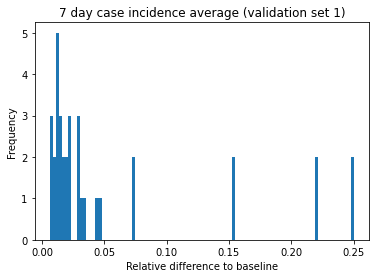

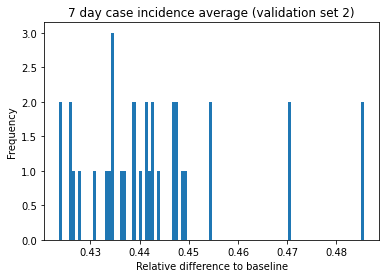

,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,rank1,rank2,overallRank,modelClass,model rmse 1,model rmse 2
modelId,,,,,,,,
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage/mean,0.221084,0.454351,3.0,5.0,1.0,MultiTaskLasso mean,30.915292,57.483436
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.6/tol=1e-05/task=case_inz_entries_7dayAverage/mean,0.154214,0.470405,5.0,3.0,1.0,MultiTaskLasso mean,33.569399,55.792100
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=0.0001/task=case_inz_entries_7dayAverage/mean,0.220903,0.454351,4.0,6.0,2.0,MultiTaskLasso mean,30.922508,57.483465
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.6/tol=0.0001/task=case_inz_entries_7dayAverage/mean,0.154021,0.470395,6.0,4.0,2.0,MultiTaskLasso mean,33.577063,55.793151
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.5/tol=1e-05/task=case_inz_entries_7dayAverage/mean,0.074387,0.485556,7.0,1.0,3.0,MultiTaskLasso mean,36.737725,54.196016
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.5/tol=0.0001/task=case_inz_entries_7dayAverage/mean,0.074237,0.485538,8.0,2.0,4.0,MultiTaskLasso mean,36.743697,54.197922
modelClass=Keras/isMultiWeek=True/hiddenLayers=[80]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=1.0/alpha=0.01/dropoutValue=0.3/learningRate=0.0001/task=case_inz_entries_7dayAverage/mean,0.023250,0.442782,17.0,15.0,5.0,Keras mean,38.767371,58.702169
modelClass=Keras/isMultiWeek=True/hiddenLayers=[225]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=1.0/alpha=0.1/dropoutValue=0.2/learningRate=0.0001/task=case_inz_entries_7dayAverage/mean,0.018907,0.441328,19.0,18.0,6.0,Keras mean,38.939753,58.855373
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.8/tol=0.0001/task=case_inz_entries_7dayAverage/mean,0.250278,0.439115,2.0,20.0,7.0,MultiTaskLasso mean,29.756585,59.088547


'---------------------------------'

'hosp_inz_entries_7dayAverage'

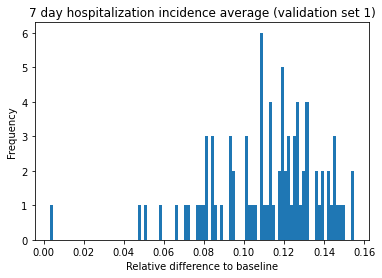

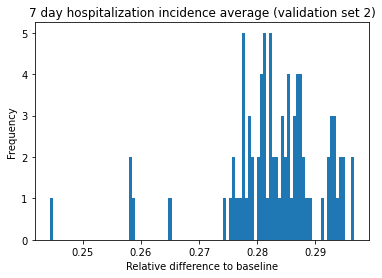

,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,rank1,rank2,overallRank,modelClass,model rmse 1,model rmse 2
modelId,,,,,,,,
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.0139999999999999/tol=0.0001/task=hosp_inz_entries_7dayAverage/mean,0.145909,0.294981,6.0,4.0,1.0,MultiTaskLasso mean,1.893996,2.698678
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.0139999999999999/tol=1e-05/task=hosp_inz_entries_7dayAverage/mean,0.145753,0.294984,7.0,3.0,2.0,MultiTaskLasso mean,1.894341,2.698667
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.015/tol=1e-05/task=hosp_inz_entries_7dayAverage/mean,0.154780,0.293533,2.0,8.0,3.0,MultiTaskLasso mean,1.874324,2.704220
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.015/tol=0.0001/task=hosp_inz_entries_7dayAverage/mean,0.155067,0.293525,1.0,9.0,4.0,MultiTaskLasso mean,1.873687,2.704253
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.013000000000000001/tol=1e-05/task=hosp_inz_entries_7dayAverage/mean,0.132084,0.296700,18.0,2.0,5.0,MultiTaskLasso mean,1.924653,2.692100
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.013000000000000001/tol=0.0001/task=hosp_inz_entries_7dayAverage/mean,0.132030,0.296704,19.0,1.0,6.0,MultiTaskLasso mean,1.924773,2.692083
modelClass=Keras/isMultiWeek=True/hiddenLayers=[80]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=hosp_inz_entries_7dayAverage/mean,0.142858,0.287600,10.0,21.0,7.0,Keras mean,1.900761,2.726933
modelClass=Keras/isMultiWeek=True/hiddenLayers=[100]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.0/dropoutValue=0.5/learningRate=0.0001/task=hosp_inz_entries_7dayAverage/mean,0.137937,0.287586,14.0,22.0,8.0,Keras mean,1.911673,2.726987
modelClass=Keras/isMultiWeek=True/hiddenLayers=[125]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.0/dropoutValue=0.5/learningRate=0.0001/task=hosp_inz_entries_7dayAverage/mean,0.127251,0.287243,25.0,25.0,9.0,Keras mean,1.935371,2.728299


'---------------------------------'

'death_inz_entries_7dayAverage'

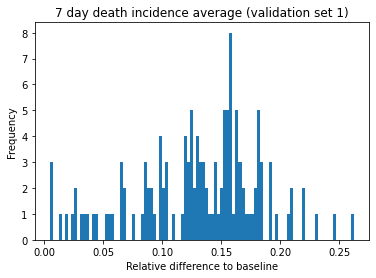

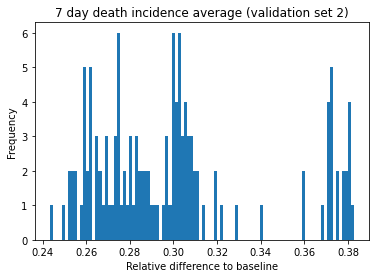

,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,rank1,rank2,overallRank,modelClass,model rmse 1,model rmse 2
modelId,,,,,,,,
modelClass=Lasso/isMultiWeek=True/alpha=0.0009/tol=0.0001/task=death_inz_entries_7dayAverage/mean,0.183169,0.375695,13.0,10.0,1.0,Lasso mean,0.744526,1.273547
modelClass=Lasso/isMultiWeek=True/alpha=0.0009/tol=1e-05/task=death_inz_entries_7dayAverage/mean,0.182917,0.375686,14.0,11.0,2.0,Lasso mean,0.744755,1.273566
modelClass=Lasso/isMultiWeek=True/alpha=0.001/tol=0.0001/task=death_inz_entries_7dayAverage/mean,0.182785,0.372900,15.0,12.0,3.0,Lasso mean,0.744875,1.279250
modelClass=Lasso/isMultiWeek=True/alpha=0.001/tol=1e-05/task=death_inz_entries_7dayAverage/mean,0.182574,0.372878,16.0,13.0,4.0,Lasso mean,0.745067,1.279293
modelClass=Lasso/isMultiWeek=True/alpha=0.0008/tol=0.0001/task=death_inz_entries_7dayAverage/mean,0.182311,0.377929,17.0,8.0,5.0,Lasso mean,0.745308,1.268990
modelClass=Lasso/isMultiWeek=True/alpha=0.0008/tol=1e-05/task=death_inz_entries_7dayAverage/mean,0.182253,0.377896,18.0,9.0,6.0,Lasso mean,0.745360,1.269058
modelClass=Lasso/isMultiWeek=True/alpha=0.0007/tol=0.0001/task=death_inz_entries_7dayAverage/mean,0.178095,0.379535,21.0,6.0,7.0,Lasso mean,0.749150,1.265714
modelClass=Lasso/isMultiWeek=True/alpha=0.0007/tol=1e-05/task=death_inz_entries_7dayAverage/mean,0.178082,0.379511,22.0,7.0,8.0,Lasso mean,0.749162,1.265764
modelClass=ElasticNet/isMultiWeek=True/alpha=0.001/l1_ratio=0.9/tol=0.0001/task=death_inz_entries_7dayAverage/mean,0.172921,0.371857,24.0,16.0,9.0,ElasticNet mean,0.753866,1.281377


'---------------------------------'

'testPositvity_7dayAverage'

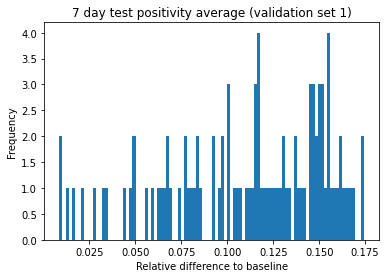

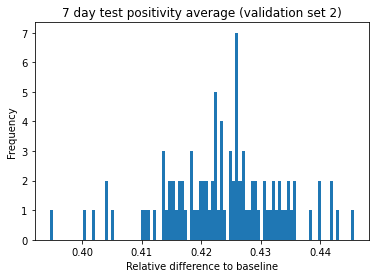

,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,rank1,rank2,overallRank,modelClass,model rmse 1,model rmse 2
modelId,,,,,,,,
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.0/alpha=0.0001/dropoutValue=0.0/learningRate=0.0001/task=testPositvity_7dayAverage/mean",0.152951,0.433879,16.0,14.0,1.0,Keras mean,0.093234,0.166927
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[1000, 500, 250]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.0/alpha=0.0001/dropoutValue=0.0/learningRate=0.0001/task=testPositvity_7dayAverage/mean",0.167191,0.432506,4.0,17.0,2.0,Keras mean,0.091667,0.167332
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[400, 200, 100]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.0/alpha=0.0001/dropoutValue=0.0/learningRate=0.0001/task=testPositvity_7dayAverage/mean",0.152000,0.434056,18.0,13.0,3.0,Keras mean,0.093339,0.166875
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[400, 100, 50]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.0/alpha=0.0001/dropoutValue=0.0/learningRate=0.0001/task=testPositvity_7dayAverage/mean",0.149806,0.438188,20.0,7.0,4.0,Keras mean,0.093581,0.165656
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[200, 200]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.0/alpha=0.0001/dropoutValue=0.0/learningRate=0.0001/task=testPositvity_7dayAverage/mean",0.154457,0.429086,15.0,26.0,5.0,Keras mean,0.093069,0.168340
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[200, 100]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.0/alpha=0.0001/dropoutValue=0.0/learningRate=0.0001/task=testPositvity_7dayAverage/mean",0.146606,0.433297,26.0,15.0,5.0,Keras mean,0.093933,0.167099
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[225, 112, 56]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.0/alpha=0.0001/dropoutValue=0.0/learningRate=0.0001/task=testPositvity_7dayAverage/mean",0.146199,0.439680,27.0,6.0,6.0,Keras mean,0.093978,0.165216
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[175, 87]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.0/alpha=0.0001/dropoutValue=0.0/learningRate=0.0001/task=testPositvity_7dayAverage/mean",0.160987,0.428743,9.0,27.0,6.0,Keras mean,0.092350,0.168441
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[400, 200, 50]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.0/alpha=0.0001/dropoutValue=0.0/learningRate=0.0001/task=testPositvity_7dayAverage/mean",0.144645,0.441706,30.0,4.0,7.0,Keras mean,0.094149,0.164619


'---------------------------------'

'transit_stations_percent_change_from_baseline_7dayAverage'

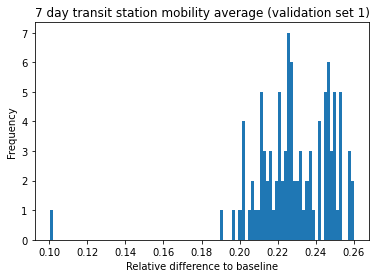

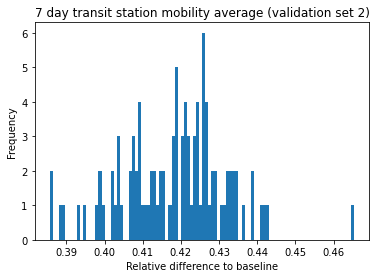

,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,rank1,rank2,overallRank,modelClass,model rmse 1,model rmse 2
modelId,,,,,,,,
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/mean",0.249285,0.436308,15.0,7.0,1.0,Keras mean,25.706724,26.668026
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 350]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/mean",0.252629,0.430480,9.0,17.0,2.0,Keras mean,25.592212,26.943777
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.01/alpha=0.001/dropoutValue=0.3/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/mean",0.247152,0.427986,20.0,21.0,3.0,Keras mean,25.779745,27.061736
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[400, 200]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.01/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/mean",0.259234,0.426965,2.0,23.0,4.0,Keras mean,25.366036,27.110051
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[400, 400]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/mean",0.245972,0.431233,23.0,16.0,4.0,Keras mean,25.820168,26.908130
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 350]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/mean",0.250115,0.425986,12.0,28.0,5.0,Keras mean,25.678282,27.156388
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.0/alpha=0.01/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/mean",0.242331,0.428062,31.0,20.0,6.0,Keras mean,25.944834,27.058149
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.01/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/mean",0.242156,0.426287,32.0,27.0,7.0,Keras mean,25.950834,27.142149
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[250, 125, 62]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.01/alpha=0.0/dropoutValue=0.2/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/mean",0.241660,0.426638,33.0,25.0,8.0,Keras mean,25.967806,27.125511


'---------------------------------'

'workplaces_percent_change_from_baseline_7dayAverage'

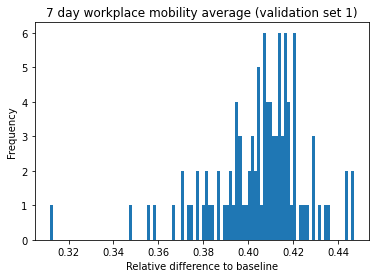

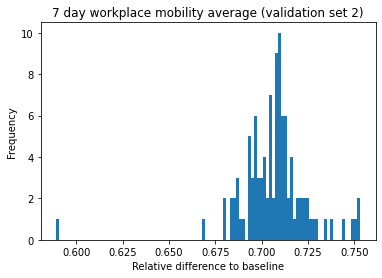

,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,rank1,rank2,overallRank,modelClass,model rmse 1,model rmse 2
modelId,,,,,,,,
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage/mean,0.418106,0.743701,22.0,5.0,1.0,RandomForrest mean,26.855556,13.361149
modelClass=Keras/isMultiWeek=True/hiddenLayers=[1000]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.0/dropoutValue=0.2/learningRate=0.001/task=workplaces_percent_change_from_baseline_7dayAverage/mean,0.430994,0.716313,7.0,22.0,1.0,Keras mean,26.260759,14.788947
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[400, 400]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.01/alpha=0.001/dropoutValue=0.2/learningRate=0.001/task=workplaces_percent_change_from_baseline_7dayAverage/mean",0.416941,0.715482,26.0,24.0,2.0,Keras mean,26.909313,14.832261
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 350]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.01/alpha=0.001/dropoutValue=0.2/learningRate=0.001/task=workplaces_percent_change_from_baseline_7dayAverage/mean",0.419025,0.712574,20.0,31.0,3.0,Keras mean,26.813144,14.983843
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[1000, 500]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.01/alpha=0.0001/dropoutValue=0.2/learningRate=0.001/task=workplaces_percent_change_from_baseline_7dayAverage/mean",0.415473,0.711498,31.0,34.0,4.0,Keras mean,26.977056,15.039912
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.01/alpha=0.0/dropoutValue=0.2/learningRate=0.001/task=workplaces_percent_change_from_baseline_7dayAverage/mean",0.420808,0.711247,17.0,36.0,5.0,Keras mean,26.730849,15.053030
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=4/task=workplaces_percent_change_from_baseline_7dayAverage/mean,0.413784,0.749185,37.0,4.0,6.0,RandomForrest mean,27.055006,13.075262
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[1000, 500]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.01/alpha=0.001/dropoutValue=0.2/learningRate=0.001/task=workplaces_percent_change_from_baseline_7dayAverage/mean",0.413452,0.710443,39.0,39.0,7.0,Keras mean,27.070360,15.094922
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[250, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.01/alpha=0.0001/dropoutValue=0.2/learningRate=0.001/task=workplaces_percent_change_from_baseline_7dayAverage/mean",0.413019,0.713235,40.0,28.0,8.0,Keras mean,27.090316,14.949403


'---------------------------------'

In [6]:
# model selection process (rank iterative)
# first we compute the attributes of all estimators, they are defined by the model id
# so we have multiple entries because of the weeks, tasks, iterations

resultsCopy = results.copy() 
resultsCopy = resultsCopy.drop_duplicates(['modelId'])
resultsCopy.drop(['task','Unnamed: 0','week','last value baseline 1 rmse','last value baseline 2 rmse','model rmse 1','model rmse 2', 'iteration'], axis=1, inplace=True)
attributesByModelId = resultsCopy.set_index('modelId')



pd.options.display.max_rows = 10

# we again copy the results and look only at the interested part
resultsCopy = results.copy()
resultsCopy = resultsCopy[['modelId','modelClass','task','week','model rmse 1','model rmse 2','last value baseline 1 rmse','last value baseline 2 rmse','iteration']]

# shift week number by one
resultsCopy['week'] = resultsCopy['week']+1


tasksDict = {}
rankedTasksDict = {}


for task in ['case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity_7dayAverage',
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage'
                   ]:
    display(task)
    
    # filter by task
    df = resultsCopy[resultsCopy['task']==task]

    
    # sum up the same machine learning models over all 4 weeks which were trainded only once
    taskResults = df[~df['modelClass'].str.contains("mean")].groupby(['modelId']).sum()
    #taskResults = taskResults.drop(['iteration'], axis=1)
    
    # get the models which were trained 30 times, for every iteration and model do the same as for the models
    # which were trained only once
    temp = df[df['modelClass'].str.contains("mean")].groupby(['modelId','iteration']).sum().reset_index()
    # add tag to the id so the modelid stays unique when we later merge the dataframe with the multiple and single
    # trained models
    temp['modelId'] = temp['modelId']+"/mean"
    # compute the mean from the iterations
    temp = temp.groupby(['modelId']).mean().drop(['iteration'], axis=1)
    
    
    
    
    # add the attribute data for the models which were trained only once
    taskResults = taskResults.join(attributesByModelId)
    
    #other join (we reset, modify and set the index again for an index join)
    attributesByModelIdForMean = attributesByModelId.reset_index()
    attributesByModelIdForMean['modelId'] = attributesByModelIdForMean['modelId'] +"/mean"
    attributesByModelIdForMean = attributesByModelIdForMean.set_index('modelId')
    temp = temp.join(attributesByModelIdForMean)
    
    # merge both single and multiple trained estimators
    taskResults = taskResults.append(temp)
    
    # add relative score based on the last value baseline
    taskResults['rel. diff. to last value baseline 1'] = (taskResults['last value baseline 1 rmse']-taskResults['model rmse 1'])/taskResults['last value baseline 1 rmse']
    taskResults['rel. diff. to last value baseline 2'] = (taskResults['last value baseline 2 rmse']-taskResults['model rmse 2'])/taskResults['last value baseline 2 rmse']
    #taskResults = taskResults.sort_values(['model rmse 1'], ascending=True)
    
    
    # safe the summarized model results in dictionary
    tasksDict[task] = taskResults.copy()
    
    # filter so that only models which perform better than the baseline in both validation sets are considered
    # this filters estimator which were highly overfitted for one of both validation sets
    taskResults = taskResults[(taskResults['rel. diff. to last value baseline 1'] >= 0) & (taskResults['rel. diff. to last value baseline 2'] >= 0)]
    

    # TURN THIS OFF IF YOU WANT TO INCLUDE THE PERFORMANCE OF MODELS WHICH WERE TRAINED ONLY ONCE
    # ATTENTION: THE ALGORITHM WILL THEN SELECT MODELS WHICH WERE LUCKY ONCE BUT THEIR PERFORMANCE IS SIGNIFICANTLY 
    # DEACREASING ON AVERAGE
    taskResults = taskResults[(taskResults['modelClass'].str.contains("mean"))]
    
    # Selection algorihtm: the algorithm works as follow, all estimators get two ranks based on their relative
    # performance for both validation sets, after that we have a sliding rank bound which starts from 1 and increases
    # whith each iteration by one. In every iteration we compute the intersection of the two sets of estimator which
    # have a rank lower or equal than our ranking bound. If the size of computed intersection increased we found one
    # or two new estimators. We then give those estimator the overall rank kBest and increas kBest by 1.
    # We stop when the intersection size is as large as the input (n)
    # The worst case for the number of iterations is n
    
    taskResults['rank1'] = taskResults['rel. diff. to last value baseline 1'].rank(ascending = False)
    taskResults['rank2'] = taskResults['rel. diff. to last value baseline 2'].rank(ascending = False)
    
    taskResults['overallRank'] = np.nan
    rankBound = 1
    kBest = 1 
    #minIntersectionSizeStop = 10
    previousIntersection = pd.DataFrame()
    
    while (previousIntersection.shape[0] < taskResults.shape[0]): # we stop at the latest when we went through the whole dataframe
        # compute intersection
        intersection = taskResults[(taskResults['rank1'] <= rankBound) & (taskResults['rank2'] <= rankBound)]
        
        # check intersection
        if intersection.shape[0] > previousIntersection.shape[0]:
            # we found more estimatiors in our intersection than before
         
            estimatorRows =  intersection[['overallRank']]
            
            difference = (estimatorRows.index).difference(previousIntersection.index, sort=False)
            
            # update the overall rank of the new found estimator
            taskResults.loc[difference, 'overallRank'] = kBest
            
            kBest = kBest + 1
            previousIntersection = intersection
            '''
            if(intersection.shape[0] >= minIntersectionSizeStop):
                break
            '''
                
        rankBound = rankBound + 1
        

    taskResults = taskResults.sort_values(['overallRank'], ascending=True)

    
    # show the distribution of the relative performance for those models
    figure = taskResults[["rel. diff. to last value baseline 1"]].plot.hist(by=None, bins=100, title=plottingDict[task] +" (validation set 1)", xlabel="relative difference to baseline", legend=False)
    figure.set_xlabel("Relative difference to baseline")
    figure.set_ylabel("Frequency")
    plt.show()
    #figure.get_figure().savefig('plots/performanceDistribution/'+task+'_1.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))
    figure = taskResults[["rel. diff. to last value baseline 2"]].plot.hist(by=None, bins=100, title=plottingDict[task]+" (validation set 2)", xlabel="relative difference to baseline", legend=False)
    figure.set_xlabel("Relative difference to baseline")
    figure.set_ylabel("Frequency")
    plt.show()
    #figure.get_figure().savefig('plots/performanceDistribution/'+task+'_2.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))
    
    # show top estimators
    display(taskResults[taskResults['overallRank'].notna()].head(10)[['rel. diff. to last value baseline 1','rel. diff. to last value baseline 2','rank1','rank2','overallRank','modelClass','model rmse 1','model rmse 2']])
    
    rankedTasksDict[task] = taskResults.copy()
    
    display("---------------------------------")
    

In [7]:
# SELECTED MODELS TRAINED ON TRAINING DATA

pd.options.display.max_columns = 25



#modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001
                  
selectedDict = {
    'case_inz_entries_7dayAverage':'modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05',
    'hosp_inz_entries_7dayAverage':'modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001',
    'death_inz_entries_7dayAverage':'modelClass=Lasso/isMultiWeek=True/alpha=0.0009/tol=0.0001',
    'testPositvity_7dayAverage':'modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001',
    'transit_stations_percent_change_from_baseline_7dayAverage':'modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001',
    'workplaces_percent_change_from_baseline_7dayAverage':'modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8'
}


temp = results.copy()
for task in outputCategories: 
    t1 = temp[(~temp['modelClass'].str.contains("mean")) 
                 & (temp['task'] == task)
                 & (temp['modelId'] == selectedDict[task])
                ]
    t1['rel. diff. to last value baseline 1'] = (t1['last value baseline 1 rmse']-t1['model rmse 1'])/t1['last value baseline 1 rmse']
    t1['rel. diff. to last value baseline 2'] = (t1['last value baseline 2 rmse']-t1['model rmse 2'])/t1['last value baseline 2 rmse']
    


    display(t1[['modelClass','task','model rmse 1','model rmse 2','last value baseline 1 rmse','last value baseline 2 rmse', 'rel. diff. to last value baseline 1','rel. diff. to last value baseline 2', 'modelIdNumber']])

<ipython-input-7-70a25d5086d5>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1['rel. diff. to last value baseline 1'] = (t1['last value baseline 1 rmse']-t1['model rmse 1'])/t1['last value baseline 1 rmse']
<ipython-input-7-70a25d5086d5>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1['rel. diff. to last value baseline 2'] = (t1['last value baseline 2 rmse']-t1['model rmse 2'])/t1['last value baseline 2 rmse']


,modelClass,task,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,modelIdNumber
528,MultiTaskLasso,case_inz_entries_7dayAverage,4.534194,10.700686,6.339356,15.058855,0.284755,0.289409,139_sklearn
529,MultiTaskLasso,case_inz_entries_7dayAverage,6.585779,15.766684,8.531462,25.559603,0.228060,0.383140,139_sklearn
530,MultiTaskLasso,case_inz_entries_7dayAverage,8.537283,16.361074,10.986179,31.134417,0.222907,0.474502,139_sklearn
531,MultiTaskLasso,case_inz_entries_7dayAverage,11.258036,14.654992,13.833168,33.595827,0.186156,0.563785,139_sklearn


<ipython-input-7-70a25d5086d5>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1['rel. diff. to last value baseline 1'] = (t1['last value baseline 1 rmse']-t1['model rmse 1'])/t1['last value baseline 1 rmse']
<ipython-input-7-70a25d5086d5>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1['rel. diff. to last value baseline 2'] = (t1['last value baseline 2 rmse']-t1['model rmse 2'])/t1['last value baseline 2 rmse']


,modelClass,task,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,modelIdNumber
580,MultiTaskLasso,hosp_inz_entries_7dayAverage,0.331880,0.341747,0.496069,0.634250,0.330979,0.461180,388_sklearn
581,MultiTaskLasso,hosp_inz_entries_7dayAverage,0.479980,0.699579,0.571898,0.919705,0.160725,0.239343,388_sklearn
582,MultiTaskLasso,hosp_inz_entries_7dayAverage,0.491177,0.802462,0.537891,1.101611,0.086847,0.271556,388_sklearn
583,MultiTaskLasso,hosp_inz_entries_7dayAverage,0.590958,0.854890,0.611699,1.172244,0.033906,0.270723,388_sklearn


<ipython-input-7-70a25d5086d5>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1['rel. diff. to last value baseline 1'] = (t1['last value baseline 1 rmse']-t1['model rmse 1'])/t1['last value baseline 1 rmse']
<ipython-input-7-70a25d5086d5>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1['rel. diff. to last value baseline 2'] = (t1['last value baseline 2 rmse']-t1['model rmse 2'])/t1['last value baseline 2 rmse']


,modelClass,task,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,modelIdNumber
2168,Lasso,death_inz_entries_7dayAverage,0.130800,0.130149,0.230478,0.303566,0.432487,0.571267,207_sklearn
2169,Lasso,death_inz_entries_7dayAverage,0.171007,0.245693,0.254401,0.418173,0.327803,0.412462,207_sklearn
2170,Lasso,death_inz_entries_7dayAverage,0.231627,0.404487,0.241046,0.638819,0.039072,0.366821,207_sklearn
2171,Lasso,death_inz_entries_7dayAverage,0.211092,0.493218,0.185556,0.679386,-0.137618,0.274023,207_sklearn


<ipython-input-7-70a25d5086d5>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1['rel. diff. to last value baseline 1'] = (t1['last value baseline 1 rmse']-t1['model rmse 1'])/t1['last value baseline 1 rmse']
<ipython-input-7-70a25d5086d5>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1['rel. diff. to last value baseline 2'] = (t1['last value baseline 2 rmse']-t1['model rmse 2'])/t1['last value baseline 2 rmse']


,modelClass,task,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,modelIdNumber
285276,Keras,testPositvity_7dayAverage,0.022484,0.040829,0.017815,0.051204,-0.262132,0.202637,12483
285277,Keras,testPositvity_7dayAverage,0.019446,0.042145,0.027622,0.068715,0.296000,0.386673,12483
285278,Keras,testPositvity_7dayAverage,0.019206,0.044117,0.031583,0.082042,0.391899,0.462256,12483
285279,Keras,testPositvity_7dayAverage,0.026263,0.040777,0.033049,0.092900,0.205346,0.561063,12483


<ipython-input-7-70a25d5086d5>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1['rel. diff. to last value baseline 1'] = (t1['last value baseline 1 rmse']-t1['model rmse 1'])/t1['last value baseline 1 rmse']
<ipython-input-7-70a25d5086d5>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1['rel. diff. to last value baseline 2'] = (t1['last value baseline 2 rmse']-t1['model rmse 2'])/t1['last value baseline 2 rmse']


,modelClass,task,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,modelIdNumber
422152,Keras,transit_stations_percent_change_from_baseline_...,4.944685,4.928834,8.534961,7.782827,0.420655,0.366704,18186
422153,Keras,transit_stations_percent_change_from_baseline_...,6.995154,6.602772,7.991919,11.986544,0.124722,0.449151,18186
422154,Keras,transit_stations_percent_change_from_baseline_...,6.192012,7.048739,9.834587,13.680033,0.370384,0.484743,18186
422155,Keras,transit_stations_percent_change_from_baseline_...,6.492078,7.215148,7.881499,13.860186,0.176289,0.479434,18186


<ipython-input-7-70a25d5086d5>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1['rel. diff. to last value baseline 1'] = (t1['last value baseline 1 rmse']-t1['model rmse 1'])/t1['last value baseline 1 rmse']
<ipython-input-7-70a25d5086d5>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1['rel. diff. to last value baseline 2'] = (t1['last value baseline 2 rmse']-t1['model rmse 2'])/t1['last value baseline 2 rmse']


,modelClass,task,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,modelIdNumber
5060,RandomForrest,workplaces_percent_change_from_baseline_7dayAv...,7.274796,3.459820,8.543653,9.377905,0.148515,0.631067,327_sklearn
5061,RandomForrest,workplaces_percent_change_from_baseline_7dayAv...,6.374064,3.300697,11.407756,13.201341,0.441252,0.749973,327_sklearn
5062,RandomForrest,workplaces_percent_change_from_baseline_7dayAv...,7.151006,3.272051,13.628724,14.365826,0.475299,0.772234,327_sklearn
5063,RandomForrest,workplaces_percent_change_from_baseline_7dayAv...,6.050357,3.289399,12.571834,15.186066,0.518737,0.783394,327_sklearn


In [8]:
# SELECTED MODELS TRAINED ON TRAINING + VALIDATION DATA
df = pd.read_csv("models/trainedOnTrainingAndValidationData/correspondingResults.csv")


for task in outputCategories:
    for outputWeekNumber in range(0,numberOfOutputWeeks): # for every output week
        # get the ground truth
        groundtruth1 = test1_labels[["output_"+task+"_"+str(outputWeekNumber)]]
        groundtruth2 = test2_labels[["output_"+task+"_"+str(outputWeekNumber)]]
   
        # get the easy baseline (is the same for all output weeks)
        last_value_baseline1 = test1_features[[task+"_last_"+str(numberOfInputWeeks-1)]]
        last_value_baseline2 = test2_features[[task+"_last_"+str(numberOfInputWeeks-1)]]
        
        last_value_baseline1_rmse = np.sqrt(mean_squared_error(last_value_baseline1,groundtruth1))
        last_value_baseline2_rmse = np.sqrt(mean_squared_error(last_value_baseline2,groundtruth2))
        
        df.loc[(df.task == task) & (df.week == outputWeekNumber),'last value baseline 1 rmse']=last_value_baseline1_rmse
        df.loc[(df.task == task) & (df.week == outputWeekNumber),'last value baseline 2 rmse']=last_value_baseline2_rmse




for task in outputCategories:
    temp = df.copy()
    temp = temp[temp['task']==task]
    
    temp['rel. diff. to last value baseline 1'] = (temp['last value baseline 1 rmse']-temp['model rmse 1'])/temp['last value baseline 1 rmse']
    temp['rel. diff. to last value baseline 2'] = (temp['last value baseline 2 rmse']-temp['model rmse 2'])/temp['last value baseline 2 rmse']
    
    display(temp[['modelClass','task','model rmse 1','model rmse 2','last value baseline 1 rmse','last value baseline 2 rmse', 'rel. diff. to last value baseline 1','rel. diff. to last value baseline 2']])
    
    t = temp[['modelClass','task','model rmse 1','model rmse 2','last value baseline 1 rmse','last value baseline 2 rmse', 'rel. diff. to last value baseline 1','rel. diff. to last value baseline 2']].drop(['rel. diff. to last value baseline 1','rel. diff. to last value baseline 2'],axis=1).sum()
    t['rel. diff. to last value baseline 1'] = (t['last value baseline 1 rmse']-t['model rmse 1'])/t['last value baseline 1 rmse']
    t['rel. diff. to last value baseline 2'] = (t['last value baseline 2 rmse']-t['model rmse 2'])/t['last value baseline 2 rmse']
    display(t)


,modelClass,task,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
0,MultiTaskLasso,case_inz_entries_7dayAverage,4.798255,4.581804,6.053531,9.032787,0.207363,0.492759
1,MultiTaskLasso,case_inz_entries_7dayAverage,8.593542,9.172329,9.086627,15.290559,0.054265,0.400131
2,MultiTaskLasso,case_inz_entries_7dayAverage,12.458467,13.717996,11.351886,21.094203,-0.097480,0.349679
3,MultiTaskLasso,case_inz_entries_7dayAverage,15.774776,17.458594,13.343291,25.459919,-0.182225,0.314271


modelClass                             MultiTaskLassoMultiTaskLassoMultiTaskLassoMult...
task                                   case_inz_entries_7dayAveragecase_inz_entries_7...
model rmse 1                                                                   41.625039
model rmse 2                                                                   44.930723
last value baseline 1 rmse                                                     39.835335
last value baseline 2 rmse                                                     70.877468
rel. diff. to last value baseline 1                                            -0.044928
rel. diff. to last value baseline 2                                             0.366079
dtype: object

,modelClass,task,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
4,MultiTaskLasso,hosp_inz_entries_7dayAverage,0.327020,0.417339,0.454700,0.726119,0.280800,0.425247
5,MultiTaskLasso,hosp_inz_entries_7dayAverage,0.497755,0.500568,0.487106,0.755163,-0.021861,0.337139
6,MultiTaskLasso,hosp_inz_entries_7dayAverage,0.603220,0.535161,0.568131,0.896494,-0.061762,0.403051
7,MultiTaskLasso,hosp_inz_entries_7dayAverage,0.632403,0.532875,0.635138,0.926472,0.004306,0.424834


modelClass                             MultiTaskLassoMultiTaskLassoMultiTaskLassoMult...
task                                   hosp_inz_entries_7dayAveragehosp_inz_entries_7...
model rmse 1                                                                    2.060398
model rmse 2                                                                    1.985943
last value baseline 1 rmse                                                      2.145075
last value baseline 2 rmse                                                      3.304247
rel. diff. to last value baseline 1                                             0.039475
rel. diff. to last value baseline 2                                             0.398973
dtype: object

,modelClass,task,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
8,Lasso,death_inz_entries_7dayAverage,0.062667,0.183469,0.144920,0.497114,0.567574,0.630933
9,Lasso,death_inz_entries_7dayAverage,0.116104,0.333414,0.124847,0.569091,0.070032,0.414130
10,Lasso,death_inz_entries_7dayAverage,0.131981,0.260335,0.130285,0.539602,-0.013016,0.517542
11,Lasso,death_inz_entries_7dayAverage,0.159843,0.261726,0.143395,0.610207,-0.114705,0.571086


modelClass                                                          LassoLassoLassoLasso
task                                   death_inz_entries_7dayAveragedeath_inz_entries...
model rmse 1                                                                    0.470595
model rmse 2                                                                    1.038944
last value baseline 1 rmse                                                      0.543448
last value baseline 2 rmse                                                      2.216014
rel. diff. to last value baseline 1                                             0.134056
rel. diff. to last value baseline 2                                             0.531166
dtype: object

,modelClass,task,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
12,Keras,testPositvity_7dayAverage,0.015925,0.019919,0.013644,0.036111,-0.167164,0.448410
13,Keras,testPositvity_7dayAverage,0.017471,0.021610,0.021463,0.055182,0.185969,0.608394
14,Keras,testPositvity_7dayAverage,0.018344,0.023007,0.028603,0.070012,0.358664,0.671379
15,Keras,testPositvity_7dayAverage,0.021095,0.023133,0.036977,0.082511,0.429511,0.719640


modelClass                                                          KerasKerasKerasKeras
task                                   testPositvity_7dayAveragetestPositvity_7dayAve...
model rmse 1                                                                    0.072836
model rmse 2                                                                    0.087668
last value baseline 1 rmse                                                      0.100687
last value baseline 2 rmse                                                      0.243815
rel. diff. to last value baseline 1                                             0.276616
rel. diff. to last value baseline 2                                             0.640432
dtype: object

,modelClass,task,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
20,Keras,transit_stations_percent_change_from_baseline_...,5.562297,4.967432,8.852279,8.687829,0.371654,0.428231
21,Keras,transit_stations_percent_change_from_baseline_...,6.689804,5.757874,9.208036,12.736112,0.273482,0.547910
22,Keras,transit_stations_percent_change_from_baseline_...,6.792437,5.995693,10.199068,13.792643,0.334014,0.565298
23,Keras,transit_stations_percent_change_from_baseline_...,8.370924,6.327876,13.415656,14.057860,0.376033,0.549869


modelClass                                                          KerasKerasKerasKeras
task                                   transit_stations_percent_change_from_baseline_...
model rmse 1                                                                   27.415462
model rmse 2                                                                   23.048876
last value baseline 1 rmse                                                     41.675039
last value baseline 2 rmse                                                     49.274444
rel. diff. to last value baseline 1                                             0.342161
rel. diff. to last value baseline 2                                             0.532235
dtype: object

,modelClass,task,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
16,RandomForrest,workplaces_percent_change_from_baseline_7dayAv...,7.847195,3.732730,11.254799,9.411054,0.302769,0.603367
17,RandomForrest,workplaces_percent_change_from_baseline_7dayAv...,7.024683,4.155843,11.317050,13.601134,0.379283,0.694449
18,RandomForrest,workplaces_percent_change_from_baseline_7dayAv...,7.326736,4.625352,10.368130,14.468247,0.293341,0.680310
19,RandomForrest,workplaces_percent_change_from_baseline_7dayAv...,8.758823,4.719874,12.255308,14.913515,0.285304,0.683517


modelClass                             RandomForrestRandomForrestRandomForrestRandomF...
task                                   workplaces_percent_change_from_baseline_7dayAv...
model rmse 1                                                                   30.957437
model rmse 2                                                                   17.233799
last value baseline 1 rmse                                                     45.195286
last value baseline 2 rmse                                                      52.39395
rel. diff. to last value baseline 1                                              0.31503
rel. diff. to last value baseline 2                                             0.671073
dtype: object

/home/david/.local/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MultiTaskLasso from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


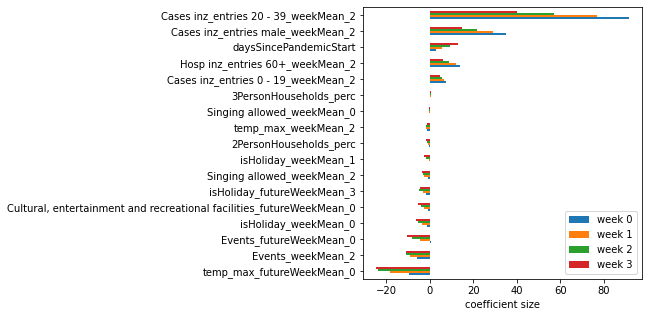

/home/david/.local/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MultiTaskLasso from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


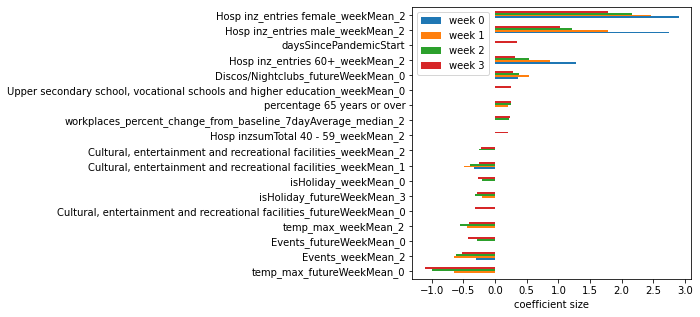

/home/david/.local/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Lasso from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


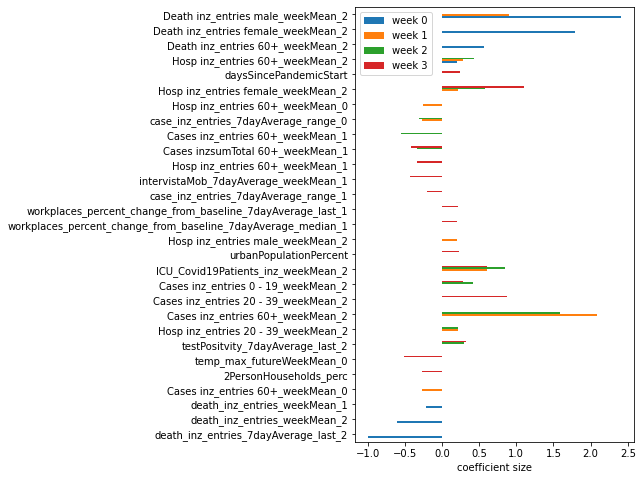

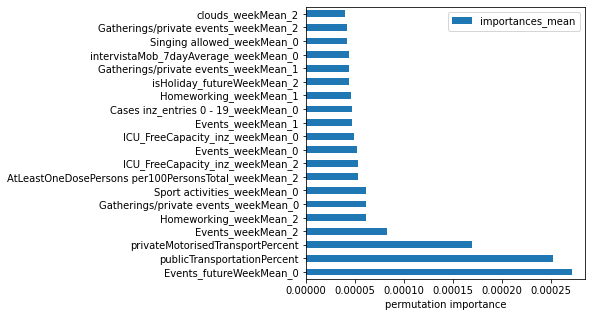

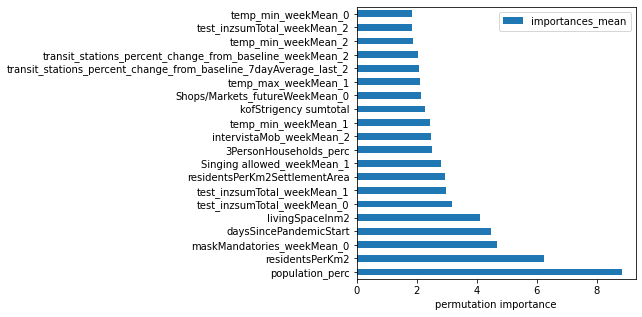

/home/david/.local/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/david/.local/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


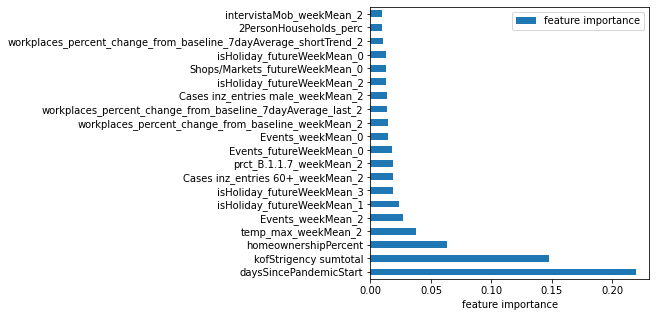

Weight,Feature
0.2196 ± 0.3024,daysSincePandemicStart
0.1478 ± 0.2940,kofStrigency sumtotal
0.0635 ± 0.0358,homeownershipPercent
0.0378 ± 0.0430,temp_max_weekMean_2
0.0268 ± 0.0525,Events_weekMean_2
0.0239 ± 0.0240,isHoliday_futureWeekMean_1
0.0190 ± 0.0166,isHoliday_futureWeekMean_3
0.0189 ± 0.0435,Cases inz_entries 60+_weekMean_2
0.0183 ± 0.0444,prct_B.1.1.7_weekMean_2
0.0182 ± 0.0375,Events_futureWeekMean_0


In [25]:
# FEATURE IMPORTANCE TRAINING SET
import eli5

# CASES
# load model
model = load('models/trainedOnTrainingData/139_case_inz_entries_7dayAverage_sklearn.pkl')
temp = pd.DataFrame(model.coef_.transpose(), columns=['week 0','week 1','week 2','week 3'],index=train_features.columns)
temp = temp[(temp['week 0'] != 0) | (temp['week 1'] != 0) | (temp['week 2'] != 0) | (temp['week 3'] != 0)].sort_values(['week 3'],ascending=True)
figure = temp.plot(kind='barh',figsize=(5,5))
figure.set_xlabel("coefficient size")
figure.set_ylabel("")
plt.show()

#figure.get_figure().savefig('plots/importanceAfterTraining/cases.png', bbox_inches=matplotlib.transforms.Bbox([[-5, 0], [5, 5]]))

display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), top=(5,5), target_names=['week 1','week 2','week 3','week 4']))



# HOSPITALIZATIONS
model = load('models/trainedOnTrainingData/388_hosp_inz_entries_7dayAverage_sklearn.pkl')
temp = pd.DataFrame(model.coef_.transpose(), columns=['week 0','week 1','week 2','week 3'],index=train_features.columns)

threshold = 0.2
temp['week 0'][temp['week 0'].abs() < threshold] = 0
temp['week 1'][temp['week 1'].abs() < threshold] = 0
temp['week 2'][temp['week 2'].abs() < threshold] = 0
temp['week 3'][temp['week 3'].abs() < threshold] = 0

temp = temp[(temp['week 0'] != 0) | (temp['week 1'] != 0) | (temp['week 2'] != 0) | (temp['week 3'] != 0)].sort_values(['week 3'],ascending=True)
figure = temp.plot(kind='barh',figsize=(5,5))
figure.set_xlabel("coefficient size")
figure.set_ylabel("")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTraining/hospitalizations.png', bbox_inches=matplotlib.transforms.Bbox([[-5, 0], [5, 5]]))

display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), top=(5,5), target_names=['week 1','week 2','week 3','week 4']))



# DEATHS
model = load('models/trainedOnTrainingData/207_death_inz_entries_7dayAverage_sklearn.pkl')
#for week in [0,1,2,3]:
temp = pd.DataFrame(model.coef_.transpose(), columns=['week 0','week 1','week 2','week 3'],index=train_features.columns)

threshold = 0.2
temp['week 0'][temp['week 0'].abs() < threshold] = 0
temp['week 1'][temp['week 1'].abs() < threshold] = 0
temp['week 2'][temp['week 2'].abs() < threshold] = 0
temp['week 3'][temp['week 3'].abs() < threshold] = 0

temp = temp[(temp['week 0'] != 0) | (temp['week 1'] != 0) | (temp['week 2'] != 0) | (temp['week 3'] != 0)].sort_values(["week 0"],ascending=True)
figure = temp.plot(kind='barh',figsize=(5,8))
figure.set_xlabel("coefficient size")
figure.set_ylabel("")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTraining/deaths.png', bbox_inches=matplotlib.transforms.Bbox([[-5, 0], [5, 8]]))
display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), top=(5,5), target_names=['week 1','week 2','week 3','week 4']))




# TEST POSITIVITY
# permutation importance
df = pd.read_csv("featureImportance/fromTrainingData/12483_testPositvity_7dayAverage.csv")
df = df.set_index("Unnamed: 0")
df.index.rename('features', inplace=True)
figure = df[["importances_mean"]].head(20).plot(kind="barh",figsize=(5,5))
figure.set_ylabel("")
figure.set_xlabel("permutation importance")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTraining/testpositivity.png', bbox_inches=matplotlib.transforms.Bbox([[-5, 0], [5, 5]]))


# TRANSIT STATION MOBILITY
# permutation importance
df = pd.read_csv("featureImportance/fromTrainingData/18186_transit_stations_percent_change_from_baseline_7dayAverage.csv")
df = df.set_index("Unnamed: 0")
df.index.rename('features', inplace=True)
figure = df[["importances_mean"]].head(20).plot(kind="barh",figsize=(5,5))
figure.set_ylabel("")
figure.set_xlabel("permutation importance")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTraining/transitstation.png', bbox_inches=matplotlib.transforms.Bbox([[-5, 0], [5, 5]]))





# WORKINGPLACE MOBILITY
model = load('models/trainedOnTrainingData/327_workplaces_percent_change_from_baseline_7dayAverage_sklearn.pkl')
temp = pd.DataFrame(model.feature_importances_, index=train_features.columns, columns=['feature importance'])
temp.index.names = ['features']
temp = temp.sort_values(['feature importance'], ascending = False).head(20)
figure = temp.plot(kind='barh',figsize=(5,5))
figure.set_xlabel("feature importance")
figure.set_ylabel("")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTraining/workingplace.png', bbox_inches=matplotlib.transforms.Bbox([[-5, 0], [5, 5]]))
display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), target_names=['week 1','week 2','week 3','week 4']))



/home/david/.local/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MultiTaskLasso from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


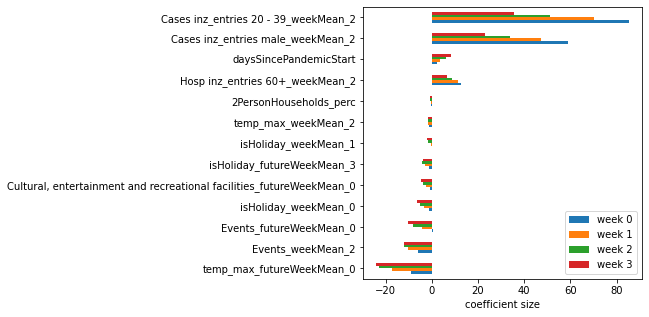

/home/david/.local/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MultiTaskLasso from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


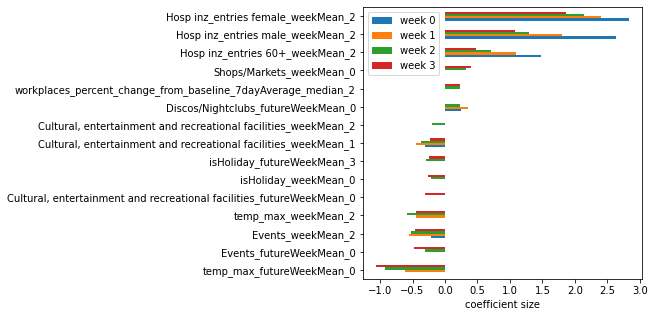

/home/david/.local/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Lasso from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


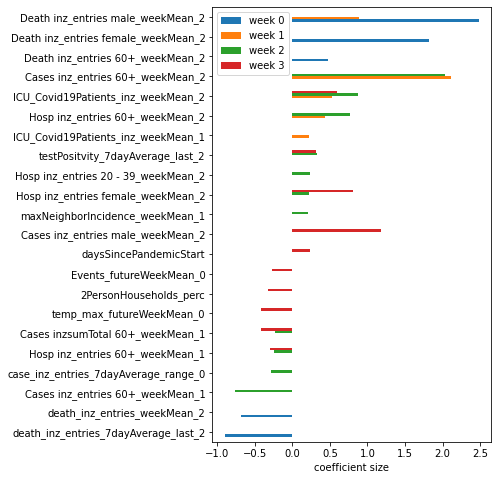

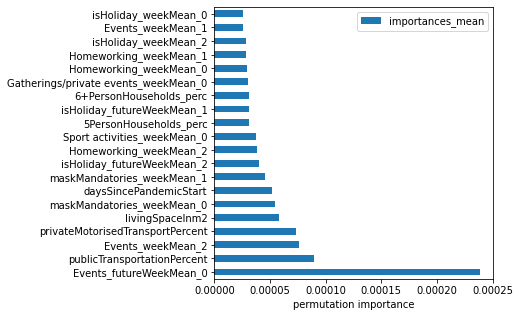

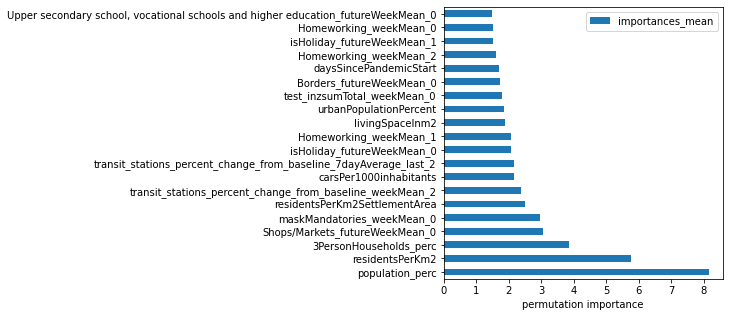

/home/david/.local/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/david/.local/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


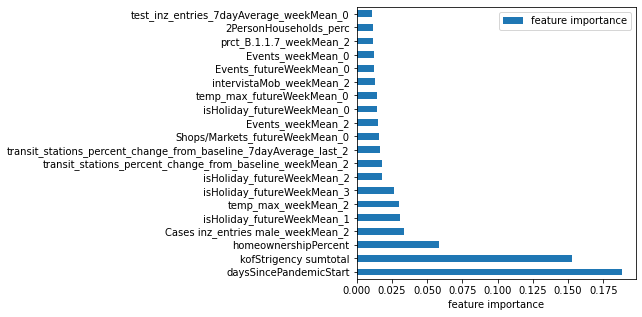

Weight,Feature
0.1886 ± 0.2903,daysSincePandemicStart
0.1525 ± 0.2815,kofStrigency sumtotal
0.0582 ± 0.0394,homeownershipPercent
0.0338 ± 0.0291,Cases inz_entries male_weekMean_2
0.0308 ± 0.0227,isHoliday_futureWeekMean_1
0.0298 ± 0.0532,temp_max_weekMean_2
0.0264 ± 0.0178,isHoliday_futureWeekMean_3
0.0178 ± 0.0313,isHoliday_futureWeekMean_2
0.0176 ± 0.0647,transit_stations_percent_change_from_baseline_weekMean_2
0.0167 ± 0.0636,transit_stations_percent_change_from_baseline_7dayAverage_last_2


In [27]:
# FEATURE IMPORTANCE TRAINING + VALIDATION SET
import eli5


# CASES
# load model
model = load('models/trainedOnTrainingAndValidationData/139_case_inz_entries_7dayAverage_sklearn.pkl')
temp = pd.DataFrame(model.coef_.transpose(), columns=['week 0','week 1','week 2','week 3'],index=train_features.columns)
temp = temp[(temp['week 0'] != 0) | (temp['week 1'] != 0) | (temp['week 2'] != 0) | (temp['week 3'] != 0)].sort_values(['week 3'],ascending=True)
figure = temp.plot(kind='barh',figsize=(5,5))
figure.set_xlabel("coefficient size")
figure.set_ylabel("")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTrainingValidating/cases.png', bbox_inches=matplotlib.transforms.Bbox([[-5, 0], [5, 5]]))
display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), top=(5,5), target_names=['week 1','week 2','week 3','week 4']))



# HOSPITALIZATIONS
model = load('models/trainedOnTrainingAndValidationData/388_hosp_inz_entries_7dayAverage_sklearn.pkl')
temp = pd.DataFrame(model.coef_.transpose(), columns=['week 0','week 1','week 2','week 3'],index=train_features.columns)

threshold = 0.2
temp['week 0'][temp['week 0'].abs() < threshold] = 0
temp['week 1'][temp['week 1'].abs() < threshold] = 0
temp['week 2'][temp['week 2'].abs() < threshold] = 0
temp['week 3'][temp['week 3'].abs() < threshold] = 0

temp = temp[(temp['week 0'].abs() > threshold) | (temp['week 1'].abs() > threshold) | (temp['week 2'].abs() > threshold) | (temp['week 3'].abs() > threshold)].sort_values(['week 3','week 0','week 1','week 2'],ascending=True)
figure = temp.plot(kind='barh',figsize=(5,5))
figure.set_xlabel("coefficient size")
figure.set_ylabel("")
#figure.get_figure().savefig('plots/importanceAfterTrainingValidating/hospitalizations.png', bbox_inches=matplotlib.transforms.Bbox([[-5, 0], [5, 5]]))
plt.show()

display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), top=(5,5), target_names=['week 1','week 2','week 3','week 4']))



# DEATHS
model = load('models/trainedOnTrainingAndValidationData/207_death_inz_entries_7dayAverage_sklearn.pkl')
temp = pd.DataFrame(model.coef_.transpose(), columns=['week 0','week 1','week 2','week 3'],index=train_features.columns)
threshold = 0.2
temp['week 0'][temp['week 0'].abs() < threshold] = 0
temp['week 1'][temp['week 1'].abs() < threshold] = 0
temp['week 2'][temp['week 2'].abs() < threshold] = 0
temp['week 3'][temp['week 3'].abs() < threshold] = 0
temp = temp[(temp['week 0'].abs() > threshold) | (temp['week 1'].abs() > threshold) | (temp['week 2'].abs() > threshold) | (temp['week 3'].abs() > threshold)].sort_values(['week 0','week 1','week 2','week 3'],ascending=True)
figure = temp.plot(kind='barh',figsize=(5,8))
figure.set_xlabel("coefficient size")
figure.set_ylabel("")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTrainingValidating/deaths.png', bbox_inches=matplotlib.transforms.Bbox([[-5, 0], [5, 8]]))
display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), top=(5,5), target_names=['week 1','week 2','week 3','week 4']))



# TEST POSITIVITY
# permutation importance
df = pd.read_csv("featureImportance/fromTrainingAndValidationData/12483_testPositvity_7dayAverage.csv")
df = df.set_index("Unnamed: 0")
df.index.rename('features', inplace=True)
figure = df[["importances_mean"]].head(20).plot(kind="barh", figsize=(5,5))
figure.set_ylabel("")
figure.set_xlabel("permutation importance")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTrainingValidating/testpositivity.png', bbox_inches=matplotlib.transforms.Bbox([[-5, 0], [5, 5]]))


# TRANSIT STATION MOBILITY
# permutation importance
df = pd.read_csv("featureImportance/fromTrainingAndValidationData/18186_transit_stations_percent_change_from_baseline_7dayAverage.csv")
df = df.set_index("Unnamed: 0")
df.index.rename('features', inplace=True)
figure = df[["importances_mean"]].head(20).plot(kind="barh", figsize=(5,5))
figure.set_ylabel("")
figure.set_xlabel("permutation importance")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTrainingValidating/transitstation.png', bbox_inches=matplotlib.transforms.Bbox([[-8, 0], [5, 5]]))





# WORKINGPLACE MOBILITY
model = load('models/trainedOnTrainingAndValidationData/327_workplaces_percent_change_from_baseline_7dayAverage_sklearn.pkl')
temp = pd.DataFrame(model.feature_importances_, index=train_features.columns, columns=['feature importance'])
temp.index.names = ['features']
temp = temp.sort_values(['feature importance'], ascending = False).head(20)
figure = temp.plot(kind='barh',figsize=(5,5))
figure.set_xlabel("feature importance")
figure.set_ylabel("")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTrainingValidating/workingplace.png', bbox_inches=matplotlib.transforms.Bbox([[-5, 0], [5, 5]]))
display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), target_names=['week 1','week 2','week 3','week 4']))


In [4]:
# performance on validation set
selectedDict = {
    'case_inz_entries_7dayAverage':'modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage',
    'hosp_inz_entries_7dayAverage':'modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.0139999999999999/tol=0.0001/task=hosp_inz_entries_7dayAverage',
    'death_inz_entries_7dayAverage':'modelClass=Lasso/isMultiWeek=True/alpha=0.0009/tol=0.0001/task=death_inz_entries_7dayAverage',
    'testPositvity_7dayAverage':'modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.0/alpha=0.0001/dropoutValue=0.0/learningRate=0.0001/task=testPositvity_7dayAverage',
    'transit_stations_percent_change_from_baseline_7dayAverage':'modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage',
    'workplaces_percent_change_from_baseline_7dayAverage':'modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage'
}

df = results.copy()
for task in outputCategories:
    display(task)
    
    temp = df[df['task'] == task]
    
    temp = temp[(temp['modelId']==selectedDict[task])]

    temp = temp.groupby(['modelId','iteration']).sum().reset_index()
    
    temp['numberOfRanEpochs'] = temp['numberOfRanEpochs'] / 4
    display(temp.describe())
    
    temp['rel. diff. to last value baseline 1'] = (temp['last value baseline 1 rmse']-temp['model rmse 1'])/temp['last value baseline 1 rmse']
    temp['rel. diff. to last value baseline 2'] = (temp['last value baseline 2 rmse']-temp['model rmse 2'])/temp['last value baseline 2 rmse']
    
    
    v1 = temp[['rel. diff. to last value baseline 1']].values.ravel()
    v2 = temp[['rel. diff. to last value baseline 2']].values.ravel()
    
    
    display("rel. diff. to last value baseline 1 mean: " + str(np.mean(v1)))
    display("rel. diff. to last value baseline 1 standard deviation: " + str(np.std(v1)))
    display("99% confidence interval: " + str(st.norm.interval(alpha=0.99, loc=np.mean(v1), scale=st.sem(v1))))
    print(" ")
    display("rel. diff. to last value baseline 2 mean: " + str(np.mean(v2)))
    display("rel. diff. to last value baseline 2 standard deviation: " + str(np.std(v2)))
    display("99% confidence interval: " + str(st.norm.interval(alpha=0.99, loc=np.mean(v2), scale=st.sem(v2))))
    display("--------------------------------")
    
   

'case_inz_entries_7dayAverage'

,iteration,Unnamed: 0,week,model rmse 1,model rmse 2,isMultiWeek,numberOfhiddenLayers,l1reg,alpha,dropoutValue,learningRate,numberOfRanEpochs,l1_ratio,n_estimators,min_samples_leaf,tol,last value baseline 1 rmse,last value baseline 2 rmse
count,30.000000,30.000000,30.0,3.000000e+01,3.000000e+01,30.0,30.0,30.0,3.000000e+01,30.0,30.0,30.0,30.0,30.0,30.0,3.000000e+01,30.000000,3.000000e+01
mean,14.500000,238.000000,6.0,3.091529e+01,5.748344e+01,4.0,0.0,0.0,2.800000e+00,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-05,39.690166,1.053487e+02
std,8.803408,140.854535,0.0,7.226896e-15,1.445379e-14,0.0,0.0,0.0,9.033621e-16,0.0,0.0,0.0,0.0,0.0,0.0,2.067632e-20,0.000000,1.445379e-14
min,0.000000,6.000000,6.0,3.091529e+01,5.748344e+01,4.0,0.0,0.0,2.800000e+00,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-05,39.690166,1.053487e+02
25%,7.250000,122.000000,6.0,3.091529e+01,5.748344e+01,4.0,0.0,0.0,2.800000e+00,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-05,39.690166,1.053487e+02
50%,14.500000,238.000000,6.0,3.091529e+01,5.748344e+01,4.0,0.0,0.0,2.800000e+00,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-05,39.690166,1.053487e+02
75%,21.750000,354.000000,6.0,3.091529e+01,5.748344e+01,4.0,0.0,0.0,2.800000e+00,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-05,39.690166,1.053487e+02
max,29.000000,470.000000,6.0,3.091529e+01,5.748344e+01,4.0,0.0,0.0,2.800000e+00,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-05,39.690166,1.053487e+02


'rel. diff. to last value baseline 1 mean: 0.2210843360501264'

'rel. diff. to last value baseline 1 standard deviation: 5.551115123125783e-17'

'99% confidence interval: (0.22108433605012637, 0.22108433605012642)'

'rel. diff. to last value baseline 2 mean: 0.45435078350702507'

'rel. diff. to last value baseline 2 standard deviation: 1.6653345369377348e-16'

'99% confidence interval: (0.454350783507025, 0.4543507835070251)'

'--------------------------------'

'hosp_inz_entries_7dayAverage'

,iteration,Unnamed: 0,week,model rmse 1,model rmse 2,isMultiWeek,numberOfhiddenLayers,l1reg,alpha,dropoutValue,learningRate,numberOfRanEpochs,l1_ratio,n_estimators,min_samples_leaf,tol,last value baseline 1 rmse,last value baseline 2 rmse
count,30.000000,30.000000,30.0,3.000000e+01,3.000000e+01,30.0,30.0,30.0,30.000,30.0,30.0,30.0,30.0,30.0,30.0,3.000000e+01,3.000000e+01,3.000000e+01
mean,14.500000,5518.000000,6.0,1.893996e+00,2.698678e+00,4.0,0.0,0.0,0.056,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-04,2.217557e+00,3.827809e+00
std,8.803408,140.854535,0.0,4.516810e-16,4.516810e-16,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.102737e-19,4.516810e-16,9.033621e-16
min,0.000000,5286.000000,6.0,1.893996e+00,2.698678e+00,4.0,0.0,0.0,0.056,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-04,2.217557e+00,3.827809e+00
25%,7.250000,5402.000000,6.0,1.893996e+00,2.698678e+00,4.0,0.0,0.0,0.056,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-04,2.217557e+00,3.827809e+00
50%,14.500000,5518.000000,6.0,1.893996e+00,2.698678e+00,4.0,0.0,0.0,0.056,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-04,2.217557e+00,3.827809e+00
75%,21.750000,5634.000000,6.0,1.893996e+00,2.698678e+00,4.0,0.0,0.0,0.056,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-04,2.217557e+00,3.827809e+00
max,29.000000,5750.000000,6.0,1.893996e+00,2.698678e+00,4.0,0.0,0.0,0.056,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-04,2.217557e+00,3.827809e+00


'rel. diff. to last value baseline 1 mean: 0.14590887847022418'

'rel. diff. to last value baseline 1 standard deviation: 2.7755575615628914e-17'

'99% confidence interval: (0.14590887847022418, 0.14590887847022418)'

'rel. diff. to last value baseline 2 mean: 0.29498101052277137'

'rel. diff. to last value baseline 2 standard deviation: 0.0'

/home/david/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/david/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


'99% confidence interval: (nan, nan)'

'--------------------------------'

'death_inz_entries_7dayAverage'

,iteration,Unnamed: 0,week,model rmse 1,model rmse 2,isMultiWeek,numberOfhiddenLayers,l1reg,alpha,dropoutValue,learningRate,numberOfRanEpochs,l1_ratio,n_estimators,min_samples_leaf,tol,last value baseline 1 rmse,last value baseline 2 rmse
count,30.000000,30.000000,30.0,30.000000,30.000000,30.0,30.0,30.0,3.000000e+01,30.0,30.0,30.0,30.0,30.0,30.0,3.000000e+01,3.000000e+01,30.000000
mean,14.500000,6958.000000,6.0,0.744526,1.273547,4.0,0.0,0.0,3.600000e-03,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-04,9.114804e-01,2.039944
std,8.803408,140.854535,0.0,0.000000,0.000000,0.0,0.0,0.0,1.323284e-18,0.0,0.0,0.0,0.0,0.0,0.0,1.102737e-19,3.387608e-16,0.000000
min,0.000000,6726.000000,6.0,0.744526,1.273547,4.0,0.0,0.0,3.600000e-03,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-04,9.114804e-01,2.039944
25%,7.250000,6842.000000,6.0,0.744526,1.273547,4.0,0.0,0.0,3.600000e-03,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-04,9.114804e-01,2.039944
50%,14.500000,6958.000000,6.0,0.744526,1.273547,4.0,0.0,0.0,3.600000e-03,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-04,9.114804e-01,2.039944
75%,21.750000,7074.000000,6.0,0.744526,1.273547,4.0,0.0,0.0,3.600000e-03,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-04,9.114804e-01,2.039944
max,29.000000,7190.000000,6.0,0.744526,1.273547,4.0,0.0,0.0,3.600000e-03,0.0,0.0,0.0,0.0,0.0,0.0,4.000000e-04,9.114804e-01,2.039944


'rel. diff. to last value baseline 1 mean: 0.1831685499837031'

'rel. diff. to last value baseline 1 standard deviation: 5.551115123125783e-17'

'99% confidence interval: (0.18316854998370308, 0.18316854998370313)'

'rel. diff. to last value baseline 2 mean: 0.3756953785052113'

'rel. diff. to last value baseline 2 standard deviation: 1.1102230246251565e-16'

'99% confidence interval: (0.37569537850521123, 0.37569537850521134)'

'--------------------------------'

'testPositvity_7dayAverage'

,iteration,Unnamed: 0,week,model rmse 1,model rmse 2,isMultiWeek,numberOfhiddenLayers,l1reg,alpha,dropoutValue,learningRate,numberOfRanEpochs,l1_ratio,n_estimators,min_samples_leaf,tol,last value baseline 1 rmse,last value baseline 2 rmse
count,30.000000,30.000000,30.0,30.000000,30.000000,30.0,30.0,30.0,3.000000e+01,30.0,3.000000e+01,30.000000,30.0,30.0,30.0,30.0,30.00000,3.000000e+01
mean,14.500000,158638.000000,6.0,0.093234,0.166927,4.0,12.0,0.0,4.000000e-04,0.0,4.000000e-04,82.966667,0.0,0.0,0.0,0.0,0.11007,2.948608e-01
std,8.803408,140.854535,0.0,0.006286,0.003161,0.0,0.0,0.0,1.102737e-19,0.0,1.102737e-19,14.570834,0.0,0.0,0.0,0.0,0.00000,5.646013e-17
min,0.000000,158406.000000,6.0,0.081729,0.162824,4.0,12.0,0.0,4.000000e-04,0.0,4.000000e-04,66.000000,0.0,0.0,0.0,0.0,0.11007,2.948608e-01
25%,7.250000,158522.000000,6.0,0.089189,0.164575,4.0,12.0,0.0,4.000000e-04,0.0,4.000000e-04,71.250000,0.0,0.0,0.0,0.0,0.11007,2.948608e-01
50%,14.500000,158638.000000,6.0,0.092284,0.166190,4.0,12.0,0.0,4.000000e-04,0.0,4.000000e-04,80.500000,0.0,0.0,0.0,0.0,0.11007,2.948608e-01
75%,21.750000,158754.000000,6.0,0.096170,0.168319,4.0,12.0,0.0,4.000000e-04,0.0,4.000000e-04,88.750000,0.0,0.0,0.0,0.0,0.11007,2.948608e-01
max,29.000000,158870.000000,6.0,0.103909,0.173577,4.0,12.0,0.0,4.000000e-04,0.0,4.000000e-04,122.000000,0.0,0.0,0.0,0.0,0.11007,2.948608e-01


'rel. diff. to last value baseline 1 mean: 0.15295131960366104'

'rel. diff. to last value baseline 1 standard deviation: 0.0561513393253953'

'99% confidence interval: (0.12609303941207795, 0.17980959979524413)'

'rel. diff. to last value baseline 2 mean: 0.43387933236188364'

'rel. diff. to last value baseline 2 standard deviation: 0.010541765299254957'

'99% confidence interval: (0.4288370005222004, 0.43892166420156686)'

'--------------------------------'

'transit_stations_percent_change_from_baseline_7dayAverage'

,iteration,Unnamed: 0,week,model rmse 1,model rmse 2,isMultiWeek,numberOfhiddenLayers,l1reg,alpha,dropoutValue,learningRate,numberOfRanEpochs,l1_ratio,n_estimators,min_samples_leaf,tol,last value baseline 1 rmse,last value baseline 2 rmse
count,30.000000,30.000000,30.0,30.000000,30.000000,30.0,30.0,3.000000e+01,3.000000e+01,30.0,3.000000e+01,30.000000,30.0,30.0,30.0,30.0,3.000000e+01,3.000000e+01
mean,14.500000,192238.000000,6.0,25.706724,26.668026,4.0,8.0,4.000000e-03,4.000000e-04,2.0,4.000000e-04,103.533333,0.0,0.0,0.0,0.0,3.424297e+01,4.730959e+01
std,8.803408,140.854535,0.0,0.543575,0.967369,0.0,0.0,8.821895e-19,1.102737e-19,0.0,1.102737e-19,23.532418,0.0,0.0,0.0,0.0,7.226896e-15,1.445379e-14
min,0.000000,192006.000000,6.0,24.337087,24.981700,4.0,8.0,4.000000e-03,4.000000e-04,2.0,4.000000e-04,58.000000,0.0,0.0,0.0,0.0,3.424297e+01,4.730959e+01
25%,7.250000,192122.000000,6.0,25.474559,25.910146,4.0,8.0,4.000000e-03,4.000000e-04,2.0,4.000000e-04,85.000000,0.0,0.0,0.0,0.0,3.424297e+01,4.730959e+01
50%,14.500000,192238.000000,6.0,25.686998,26.509143,4.0,8.0,4.000000e-03,4.000000e-04,2.0,4.000000e-04,100.500000,0.0,0.0,0.0,0.0,3.424297e+01,4.730959e+01
75%,21.750000,192354.000000,6.0,25.971618,27.309522,4.0,8.0,4.000000e-03,4.000000e-04,2.0,4.000000e-04,122.750000,0.0,0.0,0.0,0.0,3.424297e+01,4.730959e+01
max,29.000000,192470.000000,6.0,27.245131,28.725725,4.0,8.0,4.000000e-03,4.000000e-04,2.0,4.000000e-04,147.000000,0.0,0.0,0.0,0.0,3.424297e+01,4.730959e+01


'rel. diff. to last value baseline 1 mean: 0.24928456324933046'

'rel. diff. to last value baseline 1 standard deviation: 0.015607242999614251'

'99% confidence interval: (0.24181931468112433, 0.2567498118175366)'

'rel. diff. to last value baseline 2 mean: 0.4363082332988705'

'rel. diff. to last value baseline 2 standard deviation: 0.02010394117434986'

'99% confidence interval: (0.42669212633681286, 0.4459243402609281)'

'--------------------------------'

'workplaces_percent_change_from_baseline_7dayAverage'

,iteration,Unnamed: 0,week,model rmse 1,model rmse 2,isMultiWeek,numberOfhiddenLayers,l1reg,alpha,dropoutValue,learningRate,numberOfRanEpochs,l1_ratio,n_estimators,min_samples_leaf,tol,last value baseline 1 rmse,last value baseline 2 rmse
count,30.000000,30.000000,30.0,30.000000,30.000000,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,3.000000e+01,3.000000e+01
mean,14.500000,22318.000000,6.0,26.855556,13.361149,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4000.0,32.0,0.0,4.615197e+01,5.213114e+01
std,8.803408,140.854535,0.0,0.095406,0.059137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.445379e-14,7.226896e-15
min,0.000000,22086.000000,6.0,26.694533,13.256572,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4000.0,32.0,0.0,4.615197e+01,5.213114e+01
25%,7.250000,22202.000000,6.0,26.804974,13.320252,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4000.0,32.0,0.0,4.615197e+01,5.213114e+01
50%,14.500000,22318.000000,6.0,26.844845,13.359218,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4000.0,32.0,0.0,4.615197e+01,5.213114e+01
75%,21.750000,22434.000000,6.0,26.906757,13.392026,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4000.0,32.0,0.0,4.615197e+01,5.213114e+01
max,29.000000,22550.000000,6.0,27.117219,13.520165,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4000.0,32.0,0.0,4.615197e+01,5.213114e+01


'rel. diff. to last value baseline 1 mean: 0.41810593614272584'

'rel. diff. to last value baseline 1 standard deviation: 0.0020324680295225345'

'99% confidence interval: (0.4171337670640684, 0.4190781052213833)'

'rel. diff. to last value baseline 2 mean: 0.7437011824919717'

'rel. diff. to last value baseline 2 standard deviation: 0.0011153307909897415'

'99% confidence interval: (0.7431676980328191, 0.7442346669511243)'

'--------------------------------'

'case_inz_entries_7dayAverage'

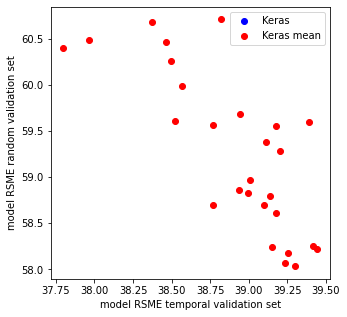

'---------------------------------------------'

'hosp_inz_entries_7dayAverage'

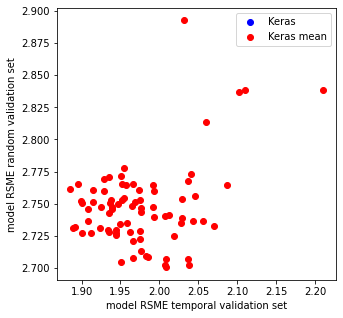

'---------------------------------------------'

'death_inz_entries_7dayAverage'

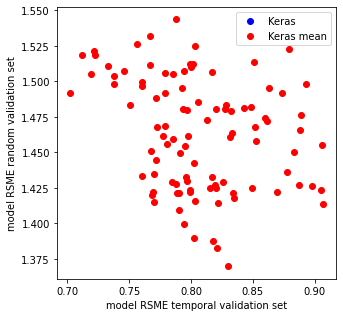

'---------------------------------------------'

'testPositvity_7dayAverage'

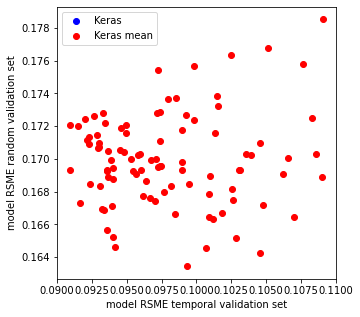

'---------------------------------------------'

'transit_stations_percent_change_from_baseline_7dayAverage'

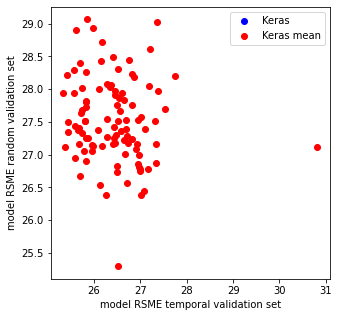

'---------------------------------------------'

'workplaces_percent_change_from_baseline_7dayAverage'

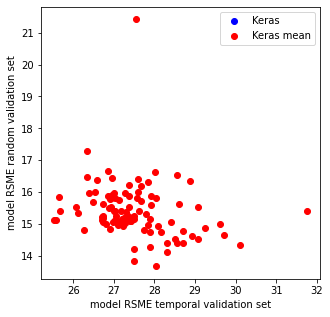

'---------------------------------------------'

In [13]:
# Keras problem
for task in ['case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity_7dayAverage',
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage'
                   ]:
    display(task)
    #temp = rankedTasksDict[task].head(100)
    #display(temp[temp['modelClass']!='Keras'])
    #display(temp[temp['modelClass']=='Keras'])
    #temp[temp['modelClass']=='Keras'].to_csv("top100/"+task+".csv")
    
    df = rankedTasksDict[task]
    
    fig = plt.figure(figsize=(5,5))
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'Keras'],
            df['model rmse 2'][df.modelClass == 'Keras'],
           marker='o',
           color='blue',
           label='Keras',
           alpha=1)
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'Keras mean'],
            df['model rmse 2'][df.modelClass == 'Keras mean'],
           marker='o',
           color='red',
           label='Keras mean',
           alpha=1)
    '''
    plt.scatter(df['model rmse 1'][df.modelClass == 'RandomForrest'],
            df['model rmse 2'][df.modelClass == 'RandomForrest'],
           marker='o',
           color='yellow',
           label='RandomForrest',
           alpha=1)
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'Ridge'],
            df['model rmse 2'][df.modelClass == 'Ridge'],
           marker='o',
           label='Ridge',
           alpha=1)
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'Lasso'],
            df['model rmse 2'][df.modelClass == 'Lasso'],
           marker='o',
           label='Lasso',
           alpha=1)
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'MultiTaskLasso'],
            df['model rmse 2'][df.modelClass == 'MultiTaskLasso'],
           marker='o',
           label='MultiTaskLasso',
           alpha=1)
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'ElasticNet'],
            df['model rmse 2'][df.modelClass == 'ElasticNet'],
           marker='o',
           color='grey',
           label='ElasticNet',
           alpha=1)
    '''
    plt.xlabel('model RSME temporal validation set')
    plt.ylabel('model RSME random validation set')
    plt.legend()

    plt.show()
    
    #fig.get_figure().savefig('plots/problemKeras/'+task+'.png', bbox_inches=matplotlib.transforms.Bbox([[-1, -1], [5, 5]]))
   
    display("---------------------------------------------")
    
    

In [5]:
# TEST SET TEST
from sklearn.pipeline import Pipeline


# settings:
numberOfInputWeeks = 3 # must be equal to the number of input weeks set in data preperator
numberOfOutputWeeks = 4 # must be equal to the number of output week set in data preperator



# data preperation
cantonKeys = ['AG','AI','AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG','ZH']
data = pd.read_csv("completedata.csv")


outputCategories = ['case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity_7dayAverage',
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage'
                   ]
numberOfOutputs = len(outputCategories)

split = numberOfOutputs * numberOfOutputWeeks + 2

train_features = data[(data['category']=='train') | (data['category']=='validation 1') | (data['category']=='validation 2')].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
train_labels = data[(data['category']=='train') | (data['category']=='validation 1') | (data['category']=='validation 2')].iloc[:,-split:-2]

test1_features = data[data['category']=='test 1'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
test1_labels = data[data['category']=='test 1'].iloc[:,-split:-2]
test2_features = data[data['category']=='test 2'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
test2_labels = data[data['category']=='test 2'].iloc[:,-split:-2]
test1And2_labels = data[(data['category']=='test 1') | (data['category']=='test 2')].iloc[:,-split:-2]
test1And2_features = data[(data['category']=='test 1') | (data['category']=='test 2')].iloc[:,0:-split].drop(['lastInputDay'], axis=1)

pip = Pipeline([('minmax_scaler', MinMaxScaler())])
X_train = pip.fit_transform(train_features[train_features.columns].values)
X_test1 = pip.transform(test1_features[train_features.columns].values)
X_test2 = pip.transform(test2_features[train_features.columns].values)
X_test1And2 = pip.transform(test1And2_features[train_features.columns].values)


for task2 in ['case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity_7dayAverage',
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage']:
    
    res = pd.DataFrame()
    for i in range(0,50):

        results = pd.read_csv("test_results/"+str(i)+".csv", low_memory=False)

        for task in outputCategories: # for all output tasks
            for outputWeekNumber in range(0,numberOfOutputWeeks): # for every output week

                # get the ground truth
                groundtruth1 = test1_labels[["output_"+task+"_"+str(outputWeekNumber)]]
                groundtruth2 = test2_labels[["output_"+task+"_"+str(outputWeekNumber)]]

                # get the easy baseline (is the same for all output weeks)
                last_value_baseline1 = test1_features[[task+"_last_"+str(numberOfInputWeeks-1)]]
                last_value_baseline2 = test2_features[[task+"_last_"+str(numberOfInputWeeks-1)]]

                last_value_baseline1_rmse = np.sqrt(mean_squared_error(last_value_baseline1,groundtruth1))
                last_value_baseline2_rmse = np.sqrt(mean_squared_error(last_value_baseline2,groundtruth2))


                results.loc[(results.task == task) & (results.week == outputWeekNumber),'last value baseline 1 rmse']=last_value_baseline1_rmse
                results.loc[(results.task == task) & (results.week == outputWeekNumber),'last value baseline 2 rmse']=last_value_baseline2_rmse


        results = results[['modelId','task','week','model rmse 1','model rmse 2','last value baseline 1 rmse','last value baseline 2 rmse']]

        results['week'] = results['week']+1


        #display(task2)
        temp2 = results[results['task']==task2]
        temp2 = temp2.groupby(['modelId']).sum()
        # add relative score
        temp2['rel. diff. to last value baseline 1'] = (temp2['last value baseline 1 rmse']-temp2['model rmse 1'])/temp2['last value baseline 1 rmse']
        temp2['rel. diff. to last value baseline 2'] = (temp2['last value baseline 2 rmse']-temp2['model rmse 2'])/temp2['last value baseline 2 rmse']
        #display(temp2)
        res = res.append(temp2)
    #st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
    display(task2)
    display(res)
    v1 = res[['rel. diff. to last value baseline 1']].values.ravel()
    display("standard deviation: " + str(np.std(res['rel. diff. to last value baseline 1'])))
    display("mean rmse 1: " + str(np.mean(v1)))
    display("99% confidence interval: " + str(st.norm.interval(alpha=0.99, loc=np.mean(v1), scale=st.sem(v1))))
    v2 = res[['rel. diff. to last value baseline 2']].values.ravel()
    display("mean rmse 2: " + str(np.mean(v2)))
    display("99% confidence interval: " + str(st.norm.interval(alpha=0.99, loc=np.mean(v2), scale=st.sem(v2))))
    #display(res)
    display(res.describe())


'case_inz_entries_7dayAverage'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
modelId,,,,,,,
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079
...,...,...,...,...,...,...,...
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079


'standard deviation: 6.938893903907228e-18'

'mean rmse 1: -0.04492754436890449'

'99% confidence interval: (-0.04492754436890449, -0.04492754436890449)'

'mean rmse 2: 0.36607889354439777'

/home/david/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/david/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


'99% confidence interval: (nan, nan)'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
count,50.0,50.000000,50.000000,50.000000,50.000000,5.000000e+01,50.000000
mean,10.0,41.625039,44.930723,39.835335,70.877468,-4.492754e-02,0.366079
std,0.0,0.000000,0.000000,0.000000,0.000000,7.009341e-18,0.000000
min,10.0,41.625039,44.930723,39.835335,70.877468,-4.492754e-02,0.366079
25%,10.0,41.625039,44.930723,39.835335,70.877468,-4.492754e-02,0.366079
50%,10.0,41.625039,44.930723,39.835335,70.877468,-4.492754e-02,0.366079
75%,10.0,41.625039,44.930723,39.835335,70.877468,-4.492754e-02,0.366079
max,10.0,41.625039,44.930723,39.835335,70.877468,-4.492754e-02,0.366079


'hosp_inz_entries_7dayAverage'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
modelId,,,,,,,
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973
...,...,...,...,...,...,...,...
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973


'standard deviation: 0.0'

'mean rmse 1: 0.03947530602641056'

/home/david/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/david/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


'99% confidence interval: (nan, nan)'

'mean rmse 2: 0.3989725306027395'

'99% confidence interval: (0.3989725306027395, 0.3989725306027395)'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
count,50.0,5.000000e+01,50.000000,5.000000e+01,5.000000e+01,50.000000,5.000000e+01
mean,10.0,2.060398e+00,1.985943,2.145075e+00,3.304247e+00,0.039475,3.989725e-01
std,0.0,4.485978e-16,0.000000,4.485978e-16,8.971957e-16,0.000000,5.607473e-17
min,10.0,2.060398e+00,1.985943,2.145075e+00,3.304247e+00,0.039475,3.989725e-01
25%,10.0,2.060398e+00,1.985943,2.145075e+00,3.304247e+00,0.039475,3.989725e-01
50%,10.0,2.060398e+00,1.985943,2.145075e+00,3.304247e+00,0.039475,3.989725e-01
75%,10.0,2.060398e+00,1.985943,2.145075e+00,3.304247e+00,0.039475,3.989725e-01
max,10.0,2.060398e+00,1.985943,2.145075e+00,3.304247e+00,0.039475,3.989725e-01


'death_inz_entries_7dayAverage'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
modelId,,,,,,,
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
...,...,...,...,...,...,...,...
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166


'standard deviation: 0.0'

'mean rmse 1: 0.1340560463583379'

/home/david/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/david/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


'99% confidence interval: (nan, nan)'

'mean rmse 2: 0.5311656532873479'

'99% confidence interval: (nan, nan)'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
count,50.0,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,10.0,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
std,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,10.0,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
25%,10.0,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
50%,10.0,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
75%,10.0,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
max,10.0,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166


'testPositvity_7dayAverage'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
modelId,,,,,,,
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.065582,0.102948,0.100687,0.243815,0.348660,0.577762
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.081694,0.089743,0.100687,0.243815,0.188635,0.631923
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.061146,0.088274,0.100687,0.243815,0.392711,0.637946
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.072003,0.085188,0.100687,0.243815,0.284889,0.650605
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.076890,0.101669,0.100687,0.243815,0.236348,0.583006
...,...,...,...,...,...,...,...
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.071218,0.096230,0.100687,0.243815,0.292687,0.605315
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.071522,0.086374,0.100687,0.243815,0.289662,0.645742
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.089336,0.088438,0.100687,0.243815,0.112734,0.637273


'standard deviation: 0.09838548030067935'

'mean rmse 1: 0.2534401845250473'

'99% confidence interval: (0.21723672692472973, 0.28964364212536486)'

'mean rmse 2: 0.6259750297761179'

'99% confidence interval: (0.6185243082153543, 0.6334257513368814)'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
count,50.0,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000
mean,10.0,0.075169,0.091193,1.006874e-01,0.243815,0.253440,0.625975
std,0.0,0.010007,0.004987,1.401868e-17,0.000000,0.099384,0.020453
min,10.0,0.059255,0.082441,1.006874e-01,0.243815,0.000356,0.577762
25%,10.0,0.067833,0.088179,1.006874e-01,0.243815,0.188277,0.612959
50%,10.0,0.074002,0.090036,1.006874e-01,0.243815,0.265036,0.630720
75%,10.0,0.081730,0.094367,1.006874e-01,0.243815,0.326300,0.638338
max,10.0,0.100652,0.102948,1.006874e-01,0.243815,0.411500,0.661873


'transit_stations_percent_change_from_baseline_7dayAverage'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
modelId,,,,,,,
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,28.189677,24.386750,41.675039,49.274444,0.323584,0.505083
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,27.121010,23.292321,41.675039,49.274444,0.349227,0.527294
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,26.759277,24.032429,41.675039,49.274444,0.357906,0.512274
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,26.084923,23.514694,41.675039,49.274444,0.374088,0.522781
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,25.740731,23.307392,41.675039,49.274444,0.382347,0.526988
...,...,...,...,...,...,...,...
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,28.531059,23.549563,41.675039,49.274444,0.315392,0.522073
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,26.749378,23.377466,41.675039,49.274444,0.358144,0.525566
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,28.617434,22.712925,41.675039,49.274444,0.313320,0.539053


'standard deviation: 0.04093267866958219'

'mean rmse 1: 0.3329928892678311'

'99% confidence interval: (0.3179306616692796, 0.34805511686638263)'

'mean rmse 2: 0.5254297423309753'

'99% confidence interval: (0.52142923183228, 0.5294302528296706)'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
count,50.0,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000
mean,10.0,27.797547,23.384185,4.167504e+01,49.274444,0.332993,0.525430
std,0.0,1.723190,0.541134,7.177566e-15,0.000000,0.041348,0.010982
min,10.0,25.397089,22.095525,4.167504e+01,49.274444,0.205663,0.500022
25%,10.0,26.692689,23.097690,4.167504e+01,49.274444,0.316147,0.518762
50%,10.0,27.597884,23.388180,4.167504e+01,49.274444,0.337784,0.525349
75%,10.0,28.499619,23.712717,4.167504e+01,49.274444,0.359504,0.531244
max,10.0,33.104044,24.636150,4.167504e+01,49.274444,0.390592,0.551582


'workplaces_percent_change_from_baseline_7dayAverage'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
modelId,,,,,,,
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,30.930260,17.248624,45.195286,52.39395,0.315631,0.670790
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,30.962149,17.258165,45.195286,52.39395,0.314925,0.670608
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,31.043203,17.241680,45.195286,52.39395,0.313132,0.670922
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,31.049152,17.299905,45.195286,52.39395,0.313000,0.669811
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,31.034440,17.263490,45.195286,52.39395,0.313326,0.670506
...,...,...,...,...,...,...,...
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,31.001127,17.335975,45.195286,52.39395,0.314063,0.669123
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,30.950453,17.225635,45.195286,52.39395,0.315184,0.671229
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,31.029262,17.278538,45.195286,52.39395,0.313440,0.670219


'standard deviation: 0.0014523846379522825'

'mean rmse 1: 0.3129536038155176'

'99% confidence interval: (0.31241916168545164, 0.3134880459455836)'

'mean rmse 2: 0.6703959291960223'

'99% confidence interval: (0.6701188058440475, 0.6706730525479971)'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
count,50.0,50.000000,50.000000,5.000000e+01,5.000000e+01,50.000000,50.000000
mean,10.0,31.051259,17.269259,4.519529e+01,5.239395e+01,0.312954,0.670396
std,0.0,0.066307,0.039859,7.177566e-15,1.435513e-14,0.001467,0.000761
min,10.0,30.883907,17.152045,4.519529e+01,5.239395e+01,0.310306,0.669123
25%,10.0,31.004667,17.243416,4.519529e+01,5.239395e+01,0.311917,0.669824
50%,10.0,31.052584,17.274607,4.519529e+01,5.239395e+01,0.312924,0.670294
75%,10.0,31.098093,17.299214,4.519529e+01,5.239395e+01,0.313984,0.670889
max,10.0,31.170920,17.335975,4.519529e+01,5.239395e+01,0.316656,0.672633


'case_inz_entries_7dayAverage'

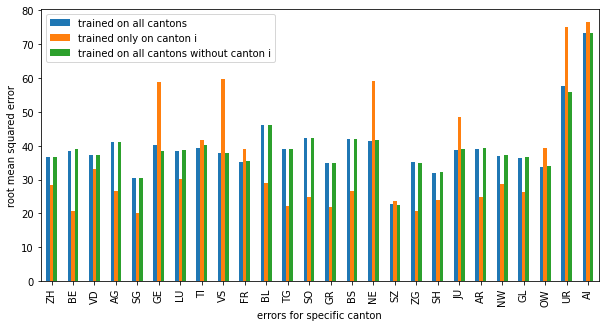

'Absolute correlations'

rel. diff. rmse 1 trained on all cantons without canton i mean: -7.78626482305821e-05
rel. diff. rmse 1 trained only on canton i mean: 0.10519078286108882


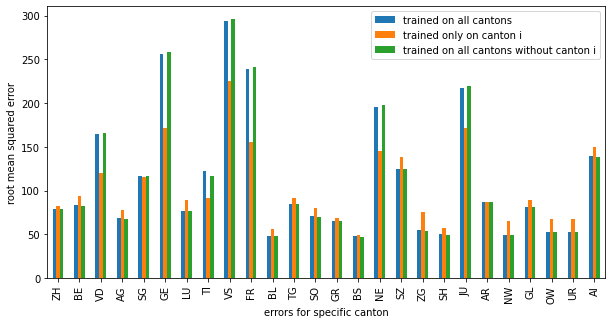

'Absolute correlations'

rel. diff. rmse 2 trained on all cantons without canton i mean: 0.004840353361968043
rel. diff. rmse 2 trained only on canton i mean: -0.026049212558631928


'------------------------------------------------------------------------------------'

'hosp_inz_entries_7dayAverage'

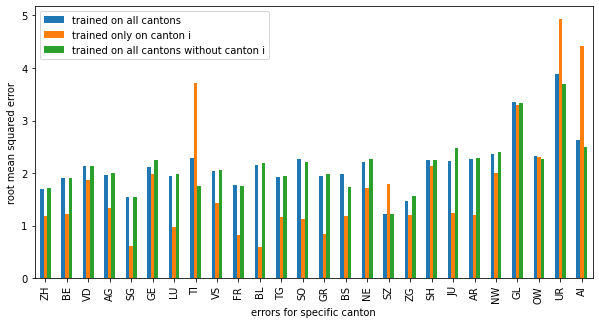

'Absolute correlations'

rel. diff. rmse 1 trained on all cantons without canton i mean: 0.0045134165413225754
rel. diff. rmse 1 trained only on canton i mean: 0.1998001684273047


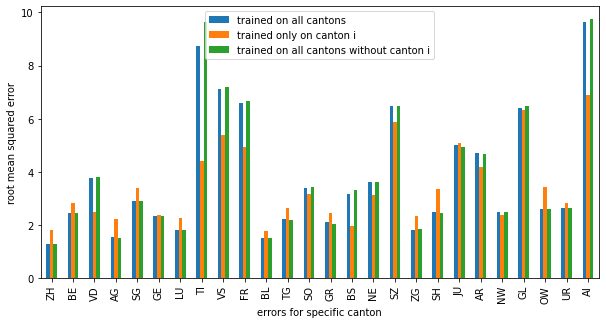

'Absolute correlations'

rel. diff. rmse 2 trained on all cantons without canton i mean: -0.005591405994213591
rel. diff. rmse 2 trained only on canton i mean: -0.019969422558353947


'------------------------------------------------------------------------------------'

'death_inz_entries_7dayAverage'

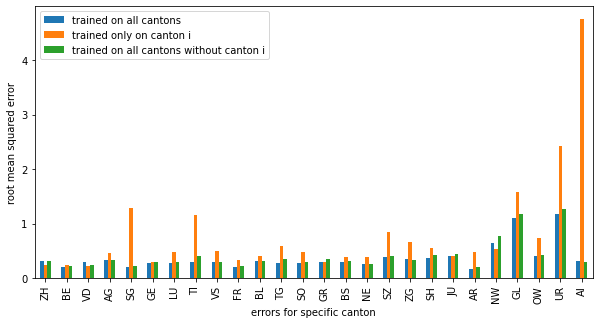

'Absolute correlations'

rel. diff. rmse 1 trained on all cantons without canton i mean: -0.06719619220834394
rel. diff. rmse 1 trained only on canton i mean: -1.2833777308486338


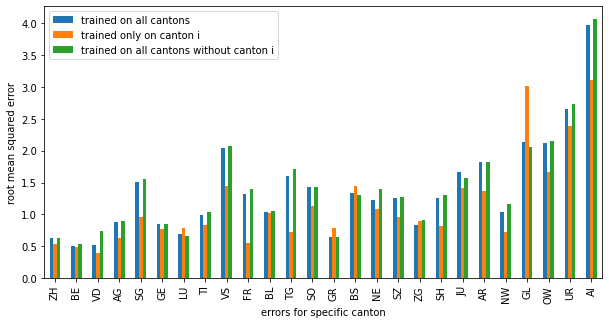

'Absolute correlations'

rel. diff. rmse 2 trained on all cantons without canton i mean: -0.04012464765346931
rel. diff. rmse 2 trained only on canton i mean: 0.15326159734633027


'------------------------------------------------------------------------------------'

'testPositvity_7dayAverage'

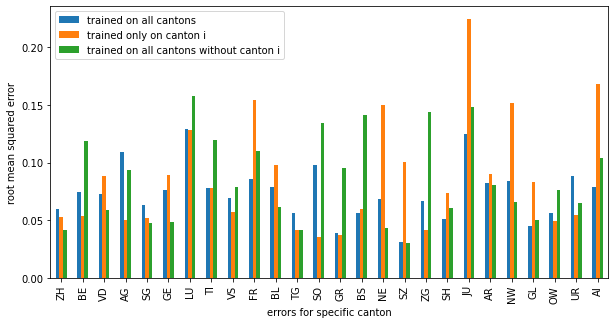

'Absolute correlations'

rel. diff. rmse 1 trained on all cantons without canton i mean: -0.18488813995163988
rel. diff. rmse 1 trained only on canton i mean: -0.2295286853226823


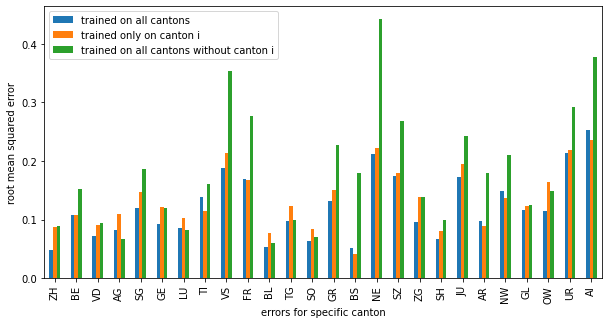

'Absolute correlations'

rel. diff. rmse 2 trained on all cantons without canton i mean: -0.4883796371028776
rel. diff. rmse 2 trained only on canton i mean: -0.15820632246862645


'------------------------------------------------------------------------------------'

'transit_stations_percent_change_from_baseline_7dayAverage'

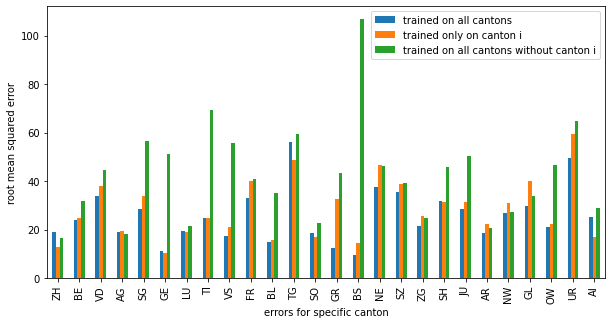

'Absolute correlations'

rel. diff. rmse 1 trained on all cantons without canton i mean: -1.0561210278583109
rel. diff. rmse 1 trained only on canton i mean: -0.14047295889354902


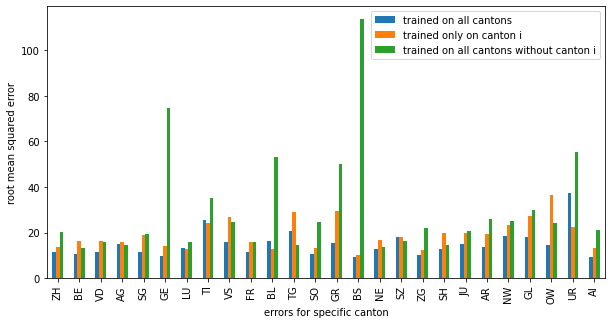

'Absolute correlations'

rel. diff. rmse 2 trained on all cantons without canton i mean: -1.2682110558930975
rel. diff. rmse 2 trained only on canton i mean: -0.33768140194242524


'------------------------------------------------------------------------------------'

'workplaces_percent_change_from_baseline_7dayAverage'

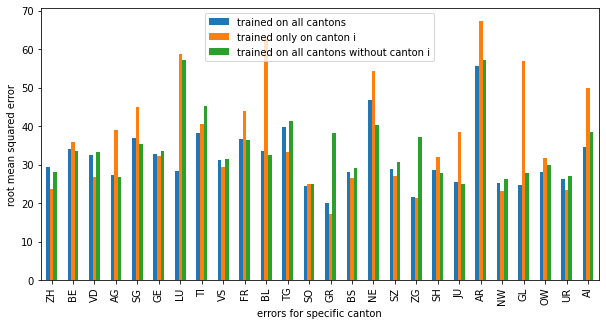

'Absolute correlations'

rel. diff. rmse 1 trained on all cantons without canton i mean: -0.11920790806547282
rel. diff. rmse 1 trained only on canton i mean: -0.18113065288230373


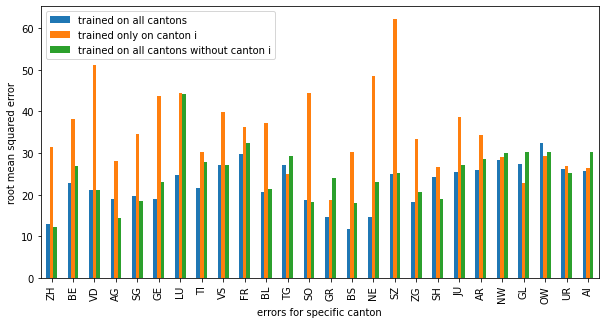

'Absolute correlations'

rel. diff. rmse 2 trained on all cantons without canton i mean: -0.12832731083455406
rel. diff. rmse 2 trained only on canton i mean: -0.6618724291847925


'------------------------------------------------------------------------------------'

In [28]:
# TRANSFERABILITY TEST
experiment1 = pd.read_csv("transferability_results/allCantonalTraining/all.csv")
#display(experiment1)
experiment1 = experiment1.groupby(['errorForCanton','task','week']).median().reset_index().groupby(['errorForCanton','task']).sum().drop(['week','iteration'], axis=1)
experiment1.rename(columns = {'model rmse 1':'rmse 1 trained on all cantons','model rmse 2':'rmse 2 trained on all cantons'}, inplace = True)
#display(experiment1)


experiment2 = pd.DataFrame()
for cantonId in cantonKeys:
    experiment2 = experiment2.append(pd.read_csv("transferability_results/allWithoutCantonI/"+cantonId+".csv"))
experiment2 = experiment2.groupby(['errorForCanton','task','week']).median().reset_index().groupby(['errorForCanton','task']).sum().drop(['week','iteration'], axis=1)
experiment2.rename(columns = {'model rmse 1':'rmse 1 trained on all cantons without canton i','model rmse 2':'rmse 2 trained on all cantons without canton i'}, inplace = True)
#display(experiment2)

experiment3 = pd.DataFrame()
for cantonId in cantonKeys:
    experiment3 = experiment3.append(pd.read_csv("transferability_results/onlyCantonI/"+cantonId+".csv"))
experiment3 = experiment3.groupby(['errorForCanton','task','week']).median().reset_index().groupby(['errorForCanton','task']).sum().drop(['week','iteration'], axis=1)
experiment3.rename(columns = {'model rmse 1':'rmse 1 trained only on canton i','model rmse 2':'rmse 2 trained only on canton i'}, inplace = True)
#display(experiment3)


transferability = pd.concat([experiment1,experiment2,experiment3], axis=1).reset_index()
#display(transferability)

# calculate relative differences to benchmark (trained on all cantons)
# for experiment 2
transferability['rel. diff. rmse 1 trained on all cantons without canton i'] = (transferability['rmse 1 trained on all cantons']-transferability['rmse 1 trained on all cantons without canton i'])/transferability['rmse 1 trained on all cantons']
transferability['rel. diff. rmse 2 trained on all cantons without canton i'] = (transferability['rmse 2 trained on all cantons']-transferability['rmse 2 trained on all cantons without canton i'])/transferability['rmse 2 trained on all cantons']
# for experiment 3
transferability['rel. diff. rmse 1 trained only on canton i'] = (transferability['rmse 1 trained on all cantons']-transferability['rmse 1 trained only on canton i'])/transferability['rmse 1 trained on all cantons']
transferability['rel. diff. rmse 2 trained only on canton i'] = (transferability['rmse 2 trained on all cantons']-transferability['rmse 2 trained only on canton i'])/transferability['rmse 2 trained on all cantons']




staticCantonal = pd.read_excel("static_data/staticCantonalData.xlsx").set_index('canton').transpose()
cantonOrder = staticCantonal.sort_values(['residents'], ascending=False).index.tolist()



for task in outputCategories:
    display(task)
    temp = transferability[transferability['task']==task].set_index('errorForCanton').drop(['task'],axis=1)
    
    
    staticCantonal = pd.read_excel("static_data/staticCantonalData.xlsx").set_index('canton').transpose()
    
    temp = temp.join(staticCantonal[['residents']])
    
    temp.sort_values('residents', inplace=True, ascending=False)
    
    temp2 = temp.copy()
    temp.rename(columns = {'rmse 1 trained on all cantons':'trained on all cantons','rmse 1 trained only on canton i':'trained only on canton i','rmse 1 trained on all cantons without canton i':'trained on all cantons without canton i'}, inplace = True)
    figure = temp[['trained on all cantons','trained only on canton i','trained on all cantons without canton i']].plot(kind='bar',figsize=(10,5))
    figure.set_ylabel("root mean squared error")
    figure.set_xlabel("errors for specific canton")
    plt.show()
    #figure.get_figure().savefig('plots/transferability/'+task+'_test1.png')
    
    # correlation between rmse and population size
    display("Absolute correlations")
    
    print('rel. diff. rmse 1 trained on all cantons without canton i mean: '+str(np.mean(temp['rel. diff. rmse 1 trained on all cantons without canton i'])))
    print('rel. diff. rmse 1 trained only on canton i mean: '+str(np.mean(temp['rel. diff. rmse 1 trained only on canton i'])))
    
    #temp.sort_values('rmse 2 trained on all cantons', inplace=True)
    temp = temp2
    temp.rename(columns = {'rmse 2 trained on all cantons':'trained on all cantons','rmse 2 trained only on canton i':'trained only on canton i','rmse 2 trained on all cantons without canton i':'trained on all cantons without canton i'}, inplace = True)
    figure = temp[['trained on all cantons','trained only on canton i','trained on all cantons without canton i']].plot(kind='bar', figsize=(10,5))
    figure.set_ylabel("root mean squared error")
    figure.set_xlabel("errors for specific canton")
    plt.show()
    #figure.get_figure().savefig('plots/transferability/'+task+'_test2.png')
    
    # correlation between rmse and population size
    display("Absolute correlations")
    
    print('rel. diff. rmse 2 trained on all cantons without canton i mean: '+str(np.mean(temp['rel. diff. rmse 2 trained on all cantons without canton i'])))
    print('rel. diff. rmse 2 trained only on canton i mean: '+str(np.mean(temp['rel. diff. rmse 2 trained only on canton i'])))
   
    display("------------------------------------------------------------------------------------")


In [16]:
# TRANSFERABILITY TEST
experiment1 = pd.read_csv("transferability_results/allCantonalTraining/all.csv")
#display(experiment1)
experiment1 = experiment1.groupby(['errorForCanton','task','week']).median().reset_index().groupby(['errorForCanton','task']).sum().drop(['week','iteration'], axis=1)
experiment1.rename(columns = {'model rmse 1':'rmse 1 trained on all cantons','model rmse 2':'rmse 2 trained on all cantons'}, inplace = True)
#display(experiment1)


experiment2 = pd.DataFrame()
for cantonId in cantonKeys:
    experiment2 = experiment2.append(pd.read_csv("transferability_results/allWithoutCantonI/"+cantonId+".csv"))
experiment2 = experiment2.groupby(['errorForCanton','task','week']).median().reset_index().groupby(['errorForCanton','task']).sum().drop(['week','iteration'], axis=1)
experiment2.rename(columns = {'model rmse 1':'rmse 1 trained on all cantons without canton i','model rmse 2':'rmse 2 trained on all cantons without canton i'}, inplace = True)
#display(experiment2)

experiment3 = pd.DataFrame()
for cantonId in cantonKeys:
    experiment3 = experiment3.append(pd.read_csv("transferability_results/onlyCantonI/"+cantonId+".csv"))
experiment3 = experiment3.groupby(['errorForCanton','task','week']).median().reset_index().groupby(['errorForCanton','task']).sum().drop(['week','iteration'], axis=1)
experiment3.rename(columns = {'model rmse 1':'rmse 1 trained only on canton i','model rmse 2':'rmse 2 trained only on canton i'}, inplace = True)
#display(experiment3)


transferability = pd.concat([experiment1,experiment2,experiment3], axis=1).reset_index()
#display(transferability)

# calculate relative differences to benchmark (trained on all cantons)
# for experiment 2
transferability['rel. diff. rmse 1 trained on all cantons without canton i'] = (transferability['rmse 1 trained on all cantons']-transferability['rmse 1 trained on all cantons without canton i'])/transferability['rmse 1 trained on all cantons']
transferability['rel. diff. rmse 2 trained on all cantons without canton i'] = (transferability['rmse 2 trained on all cantons']-transferability['rmse 2 trained on all cantons without canton i'])/transferability['rmse 2 trained on all cantons']
# for experiment 3
transferability['rel. diff. rmse 1 trained only on canton i'] = (transferability['rmse 1 trained on all cantons']-transferability['rmse 1 trained only on canton i'])/transferability['rmse 1 trained on all cantons']
transferability['rel. diff. rmse 2 trained only on canton i'] = (transferability['rmse 2 trained on all cantons']-transferability['rmse 2 trained only on canton i'])/transferability['rmse 2 trained on all cantons']


#transferability = transferability.set_index('errorForCanton')

staticCantonal = pd.read_excel("static_data/staticCantonalData.xlsx").set_index('canton').transpose()
cantonOrder = staticCantonal.sort_values(['residents'], ascending=False).index.tolist()
#display(staticCantonal.sort_values(['residents'], ascending=False).index.tolist())
'''
transferability = transferability.join(staticCantonal[['residents']])

transferability.sort_values(['residents'], inplace=True, ascending=False)
transferability = transferability.reset_index()
transferability.rename(columns = {'index':'errorForCanton'}, inplace = True)
'''
#display(transferability)

'''
for task in outputCategories:
    display(task)
    temp = transferability[transferability['task']==task].set_index('errorForCanton').drop(['task'],axis=1)
    #display(temp)
    
    staticCantonal = pd.read_excel("static_data/staticCantonalData.xlsx").set_index('canton').transpose()
    
    temp = temp.join(staticCantonal[['residents']])
    
    
    
    #display(temp)
    
    temp.sort_values('residents', inplace=True, ascending=False)
    #temp.sort_values('rmse 1 trained on all cantons', inplace=True)
    figure = temp[['rmse 1 trained on all cantons','rmse 1 trained only on canton i','rmse 1 trained on all cantons without canton i']].plot(kind='bar', title=plottingDict[task]+" transferability test set 1",figsize=(20,10))
    figure.set_ylabel("root mean squared error")
    figure.set_xlabel("errors for specific canton")
    plt.show()
    figure.get_figure().savefig('plots/transferability/'+task+'_test1.png', bbox_inches=matplotlib.transforms.Bbox([[1.8, 0.7], [18.2, 9.2]]))
    display(temp[['rmse 1 trained on all cantons','rmse 1 trained only on canton i','rmse 1 trained on all cantons without canton i']].describe())
    # correlation between rmse and population size
    display("Absolute correlations")
    display(temp[['residents','rmse 1 trained on all cantons','rmse 1 trained only on canton i','rmse 1 trained on all cantons without canton i']].corr()['residents'].sort_values(ascending=False))
    
    print('rel. diff. rmse 1 trained on all cantons without canton i mean: '+str(np.mean(temp['rel. diff. rmse 1 trained on all cantons without canton i'])))
    print('rel. diff. rmse 1 trained only on canton i mean: '+str(np.mean(temp['rel. diff. rmse 1 trained only on canton i'])))
    
    
    #display("Relative correlations (attention when interpreting this)")
    #display(temp[['residents','rel. diff. rmse 1 trained on all cantons without canton i','rel. diff. rmse 1 trained only on canton i']].corr()['residents'].sort_values(ascending=False))
    
    
    
    #temp.sort_values('rmse 2 trained on all cantons', inplace=True)
    figure = temp[['rmse 2 trained on all cantons','rmse 2 trained only on canton i','rmse 2 trained on all cantons without canton i']].plot(kind='bar', title=plottingDict[task]+" transferability test set 2", figsize=(20,10))
    figure.set_ylabel("root mean squared error")
    figure.set_xlabel("errors for specific canton")
    plt.show()
    figure.get_figure().savefig('plots/transferability/'+task+'_test2.png', bbox_inches=matplotlib.transforms.Bbox([[1.8, 0.7], [18.2, 9.2]]))
    display(temp[['rmse 2 trained on all cantons','rmse 2 trained only on canton i','rmse 2 trained on all cantons without canton i']].describe())
    # correlation between rmse and population size
    display("Absolute correlations")
    display(temp[['residents','rmse 2 trained on all cantons','rmse 2 trained only on canton i','rmse 2 trained on all cantons without canton i']].corr()['residents'].sort_values(ascending=False))
    
    print('rel. diff. rmse 2 trained on all cantons without canton i mean: '+str(np.mean(temp['rel. diff. rmse 2 trained on all cantons without canton i'])))
    print('rel. diff. rmse 2 trained only on canton i mean: '+str(np.mean(temp['rel. diff. rmse 2 trained only on canton i'])))
   
    display("------------------------------------------------------------------------------------")
'''
test1 = transferability[['errorForCanton','task','rmse 1 trained on all cantons','rmse 1 trained on all cantons without canton i','rmse 1 trained only on canton i']].copy()
test2 = transferability[['errorForCanton','task','rmse 2 trained on all cantons','rmse 2 trained on all cantons without canton i','rmse 2 trained only on canton i']].copy()


# 0 if only on canton i is best
# 1 if without canton i is best
# 2 otherwise
i1 = test1[(test1['rmse 1 trained on all cantons without canton i'] > test1['rmse 1 trained on all cantons']) & 
      (test1['rmse 1 trained on all cantons without canton i'] > test1['rmse 1 trained only on canton i'])].index
test1.loc[i1,['best']] = 1
i2 = test1[(test1['rmse 1 trained only on canton i'] > test1['rmse 1 trained on all cantons']) & 
      (test1['rmse 1 trained only on canton i'] > test1['rmse 1 trained on all cantons without canton i'])].index
test1.loc[i2,['best']] = 0
test1['best'].fillna(2, inplace = True)


j1 = test2[(test2['rmse 2 trained on all cantons without canton i'] > test2['rmse 2 trained on all cantons']) & 
      (test2['rmse 2 trained on all cantons without canton i'] > test2['rmse 2 trained only on canton i'])].index
test2.loc[j1,['best']] = 1
j2 = test2[(test2['rmse 2 trained only on canton i'] > test2['rmse 2 trained on all cantons']) & 
      (test2['rmse 2 trained only on canton i'] > test2['rmse 2 trained on all cantons without canton i'])].index
test2.loc[j2,['best']] = 0
test2['best'].fillna(2, inplace = True)



def collorMap(val):
    if val == 0:
        color = 'orange'
    elif val == 1:
        color = 'green'
    else:
        color = 'blue'
    return 'background-color: %s' % color

def collorMap2(val):
    if val == 0:
        color = 'orange'
    elif val == 1:
        color = 'green'
    else:
        color = 'blue'
    return 'color: %s' % color
  
test1 = test1[['errorForCanton','task','best']].pivot(index='task', columns='errorForCanton')
test1.columns = [y for (x,y) in test1.columns]


test2 = test2[['errorForCanton','task','best']].pivot(index='task', columns='errorForCanton')
test2.columns = [y for (x,y) in test2.columns]

test1 = test1[cantonOrder]
test1 = test1.astype(int)
test1.rename(index = {'case_inz_entries_7dayAverage':'7 day case incidence average',
                      'death_inz_entries_7dayAverage':'7 day death incidence average',
                      'hosp_inz_entries_7dayAverage':'7 day hospitalization incidence average',
                      'testPositvity_7dayAverage':'7 day test positivity average',
                      'transit_stations_percent_change_from_baseline_7dayAverage':'7 day transit station mobility average',
                      'workplaces_percent_change_from_baseline_7dayAverage':'7 day workplace mobility average'
                     }, inplace = True)

reorderlist = ['7 day case incidence average',
               '7 day hospitalization incidence average',
               '7 day death incidence average',
               '7 day test positivity average',
               '7 day transit station mobility average',
               '7 day workplace mobility average'
              ]
test1 = test1.reindex(reorderlist)

test1 = test1.style.applymap(collorMap).applymap(collorMap2)


test2 = test2[cantonOrder]
test2 = test2.astype(int)
test2.rename(index = {'case_inz_entries_7dayAverage':'7 day case incidence average',
                      'death_inz_entries_7dayAverage':'7 day death incidence average',
                      'hosp_inz_entries_7dayAverage':'7 day hospitalization incidence average',
                      'testPositvity_7dayAverage':'7 day test positivity average',
                      'transit_stations_percent_change_from_baseline_7dayAverage':'7 day transit station mobility average',
                      'workplaces_percent_change_from_baseline_7dayAverage':'7 day workplace mobility average'
                     }, inplace = True)

test2 = test2.reindex(reorderlist)

test2 = test2.style.applymap(collorMap).applymap(collorMap2)

display(test1)
display(test2)


,ZH,BE,VD,AG,SG,GE,LU,TI,VS,FR,BL,TG,SO,GR,BS,NE,SZ,ZG,SH,JU,AR,NW,GL,OW,UR,AI
task,,,,,,,,,,,,,,,,,,,,,,,,,,
7 day case incidence average,2,1,2,1,2,0,1,0,0,0,2,1,1,2,2,0,0,2,1,0,1,1,1,0,0,0
7 day hospitalization incidence average,1,1,1,1,1,1,1,0,1,2,1,1,2,1,2,1,0,1,1,1,1,1,2,2,0,0
7 day death incidence average,2,0,2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
7 day test positivity average,2,1,0,2,2,0,1,1,1,0,0,2,1,1,1,0,0,1,0,0,0,0,0,1,2,0
7 day transit station mobility average,2,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,0,1,1,1
7 day workplace mobility average,2,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,1,1,0,0,0,1,0,0,1,0


,ZH,BE,VD,AG,SG,GE,LU,TI,VS,FR,BL,TG,SO,GR,BS,NE,SZ,ZG,SH,JU,AR,NW,GL,OW,UR,AI
task,,,,,,,,,,,,,,,,,,,,,,,,,,
7 day case incidence average,0,0,1,0,1,1,0,2,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
7 day hospitalization incidence average,0,0,1,0,0,0,0,1,1,1,0,0,1,0,1,1,1,0,0,0,2,1,1,0,0,1
7 day death incidence average,2,1,1,1,1,2,0,1,1,1,1,1,2,0,0,1,1,1,1,2,1,1,0,1,1,1
7 day test positivity average,1,1,1,0,1,0,0,1,1,1,0,0,0,1,1,1,1,0,1,1,1,1,1,0,1,1
7 day transit station mobility average,1,0,0,0,1,1,1,1,0,0,1,0,1,1,1,0,0,1,0,1,1,1,1,0,1,1
7 day workplace mobility average,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,2,0,1


['Cases inz_entries female',
 'Cases inz_entries male',
 'Cases inzsumTotal female',
 'Cases inzsumTotal male',
 'Death inz_entries female',
 'Death inz_entries male',
 'Death inzsumTotal female',
 'Death inzsumTotal male',
 'Hosp inz_entries female',
 'Hosp inz_entries male',
 'Hosp inzsumTotal female',
 'Hosp inzsumTotal male',
 'AtLeastOneDosePersons per100PersonsTotal',
 'COVID19FullyVaccPersons per100PersonsTotal',
 'prct_B.1.1.7',
 'prct_B.1.351',
 'prct_P.1',
 'prct_P.2',
 'prct_B.1.617.1',
 'prct_B.1.617.2',
 'prct_B.1.525',
 'prct_B.1.526',
 'case_entries',
 'case_inz_entries',
 'case_inzsumTotal',
 'hosp_inz_entries',
 'hosp_inzsumTotal',
 'death_inz_entries',
 'death_inzsumTotal',
 'test_entries',
 'test_inz_entries',
 'test_inzsumTotal',
 'median_R_mean',
 'retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_cha

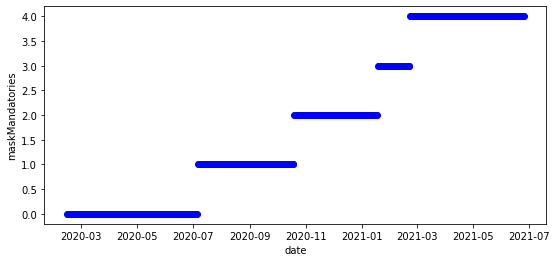

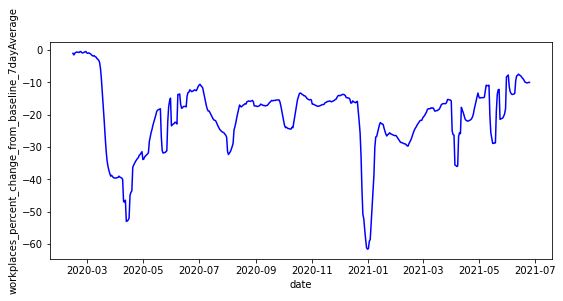

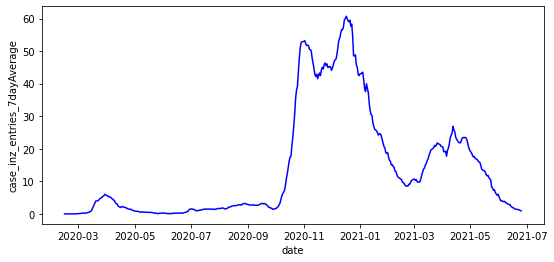

In [17]:
# visualize preperation process
start = '2020-02-15'
end = '2021-06-25'
cantonId = 'AG'

raw = pd.read_csv("data/merged/"+cantonId+".csv").set_index('date')[start:end]
raw.index = pd.to_datetime(raw.index)

processed = pd.read_csv("data/dailyFeatures/"+cantonId+".csv").set_index('date')
processed.index = pd.to_datetime(processed.index)

'''
for feature in processed.columns:
    if (feature in raw.columns):
        display(feature)
        d = pd.concat([raw[[feature]], processed[feature]],axis=1)
        d.columns = ['raw','filled & processed']

        d = d.reset_index()

        plt.figure(figsize=(9,4))
        
        plt.scatter(d['date'],
                d['filled & processed'],
               label='filled & processed',
               color='red',
               alpha=1)
        
        plt.scatter(d['date'],
                d['raw'],
               marker='o',
               color='blue',
               label='raw',
               alpha=1)
        
        plt.xlabel('date')
        plt.ylabel(feature)
        plt.legend()
        plt.savefig('plots/preparation/'+feature.replace(" ","").replace("/","")+'_'+cantonId+'.png')
        plt.show()
'''

display(processed.columns.tolist())
processed = processed.reset_index()
plt.figure(figsize=(9,4))
plt.scatter(processed['date'],
        processed['maskMandatories'],
       label='raw',
       color='blue',
       alpha=1)
plt.xlabel('date')
plt.ylabel('maskMandatories')
#plt.savefig('plots/preparation/'+'maskMandatories_'+cantonId+'.png')
plt.show()


processed = processed.reset_index()
plt.figure(figsize=(9,4))
plt.plot(processed['date'],
        processed['workplaces_percent_change_from_baseline_7dayAverage'],
       color='blue',
       alpha=1)
plt.xlabel('date')
plt.ylabel('workplaces_percent_change_from_baseline_7dayAverage')
#plt.savefig('plots/preparation/'+'workplace_'+cantonId+'.png')
plt.show()

processed = processed.reset_index()
plt.figure(figsize=(9,4))
plt.plot(processed['date'],
        processed['case_inz_entries_7dayAverage'],
       color='blue',
       alpha=1)
plt.xlabel('date')
plt.ylabel('case_inz_entries_7dayAverage')
#plt.savefig('plots/preparation/'+'caseIncidenceAverage_'+cantonId+'.png')
plt.show()




<AxesSubplot:ylabel='homeownershipPercent'>

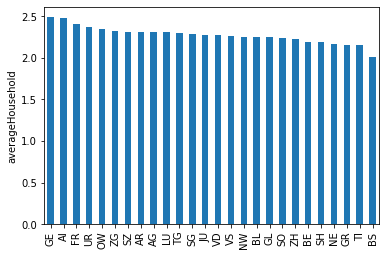

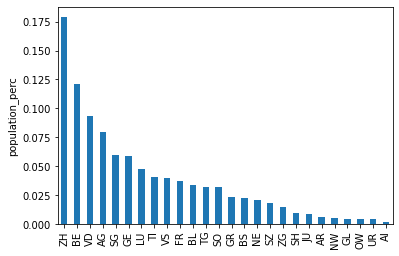

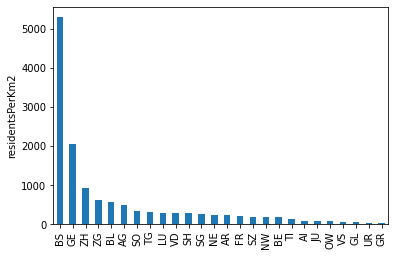

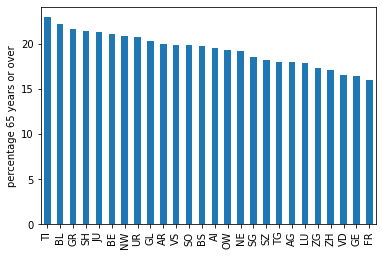

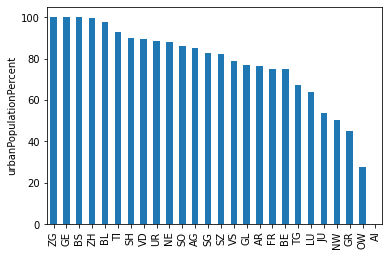

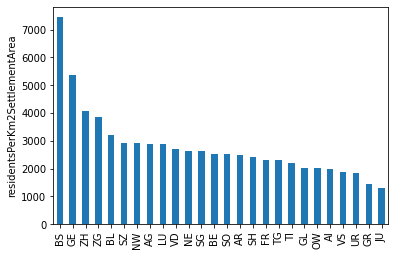

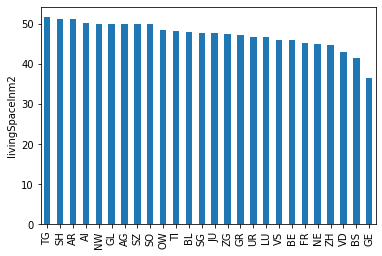

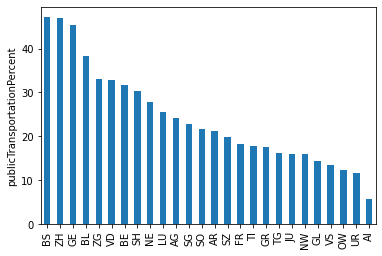

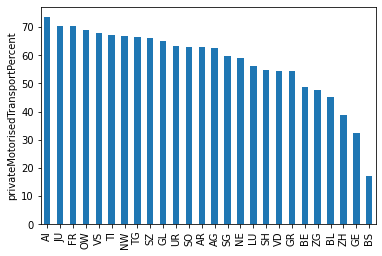

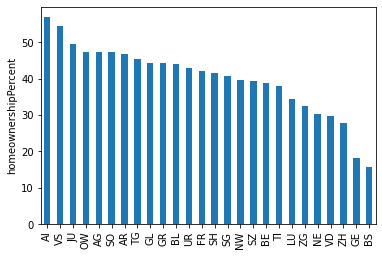

In [18]:
staticCantonal = pd.read_excel("static_data/staticCantonalData.xlsx").set_index('canton').transpose()
  

    
staticCantonal[['averageHousehold']] = staticCantonal['residents']/staticCantonal['totalHousholds']

staticCantonal[['residentsPerKm2SettlementArea']] = staticCantonal['residents']/(staticCantonal['areaInKm2']*(staticCantonal['settlementAreaPercent']/100))
staticCantonal[['population_perc']] = staticCantonal['residents']/staticCantonal['residents'].sum()


staticCantonal[['averageHousehold']].sort_values('averageHousehold',ascending=False).plot(kind='bar', ylabel='averageHousehold', legend=False)
#plt.savefig('plots/preparation/'+'averageHousehold'+'.png')
staticCantonal[['population_perc']].sort_values('population_perc',ascending=False).plot(kind='bar', ylabel='population_perc', legend=False)
#plt.savefig('plots/preparation/'+'population_perc'+'.png')
staticCantonal[['residentsPerKm2']].sort_values('residentsPerKm2',ascending=False).plot(kind='bar', ylabel='residentsPerKm2', legend=False)
#plt.savefig('plots/preparation/'+'residentsPerKm2'+'.png')
staticCantonal[['percentage 65 years or over']].sort_values('percentage 65 years or over',ascending=False).plot(kind='bar', ylabel='percentage 65 years or over', legend=False)
#plt.savefig('plots/preparation/'+'percentage65yearsorover'+'.png')
staticCantonal[['urbanPopulationPercent']].sort_values('urbanPopulationPercent',ascending=False).plot(kind='bar', ylabel='urbanPopulationPercent', legend=False)
#plt.savefig('plots/preparation/'+'urbanPopulationPercent'+'.png')
staticCantonal[['residentsPerKm2SettlementArea']].sort_values('residentsPerKm2SettlementArea',ascending=False).plot(kind='bar', ylabel='residentsPerKm2SettlementArea', legend=False)
#plt.savefig('plots/preparation/'+'residentsPerKm2SettlementArea'+'.png')
staticCantonal[['livingSpaceInm2']].sort_values('livingSpaceInm2',ascending=False).plot(kind='bar', ylabel='livingSpaceInm2', legend=False)
#plt.savefig('plots/preparation/'+'livingSpaceInm2'+'.png')
staticCantonal[['publicTransportationPercent']].sort_values('publicTransportationPercent',ascending=False).plot(kind='bar', ylabel='publicTransportationPercent', legend=False)
#plt.savefig('plots/preparation/'+'publicTransportationPercent'+'.png')
staticCantonal[['privateMotorisedTransportPercent']].sort_values('privateMotorisedTransportPercent',ascending=False).plot(kind='bar', ylabel='privateMotorisedTransportPercent', legend=False)
#plt.savefig('plots/preparation/'+'privateMotorisedTransportPercent'+'.png')
staticCantonal[['homeownershipPercent']].sort_values('homeownershipPercent',ascending=False).plot(kind='bar', ylabel='homeownershipPercent', legend=False)
#plt.savefig('plots/preparation/'+'homeownershipPercent'+'.png')

